In [1]:
import torch
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import sctokenizer
import spacy
import string
import re
from collections import Counter

import random
import torch
import torch.nn as nn
import torch.nn.init as weight_init
import torch.nn.functional as F
#from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torch import optim

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1660 Ti'

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
df = pd.read_csv("E:/BITS/2nd Year/Industry project/Dataset/c_data_twocols.zip")

In [5]:
df = df.replace(r'^\s*$', np.nan, regex=True)

In [6]:
df.head()

code  \
0  struct _CameraFile {\n        char\t\tmime_typ...   
1  struct _CameraFilesystem {\n\tCameraFilesystem...   
2  struct _CameraWidget {\n\tCameraWidgetType typ...   
3  struct _entry {\n\tchar *name;\n\tchar *value;...   
4  \tchar error[2048];\t/**< Internal kept error ...   

                                             comment  
0                                                NaN  
1  The internals of the #CameraFilesystem are onl...  
2  CameraWidget: The internals of the #CameraWidg...  
3                                                NaN  
4                       Internal kept error message.

In [7]:
df = df.dropna(axis=0)

In [8]:
df['code'] = df['code'].astype('str')
df['comment'] = df['comment'].astype('str')

In [9]:
df_train = df.head(10000)

In [10]:
from sctokenizer import CppTokenizer

ctokenizer = CppTokenizer()

In [11]:
from spacy.lang.en.stop_words import STOP_WORDS

spacy_nlp = spacy.load('en_core_web_sm')

punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [12]:
def spacy_tokenizer(sentence):
 
    #remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    #remove digits adnd words containing digits
    sentence = re.sub('\w*\d\w*','',sentence)

    #replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    #remove unwanted lines starting from special charcters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)
    
    #remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)
    
    #remove punctunations
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    
    #creating token object
    tokens = spacy_nlp(sentence)
    
    #lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    
    #remove stopwords, and exclude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]
    
    #return tokens
    return tokens

In [13]:
def str_code(x):
    tokens = ctokenizer.tokenize(x)
    string_tok = [str(i.token_value)+" "+str(i.token_type) for i in tokens]
    return string_tok

In [14]:
str_code(df_train.iat[0,0])

['struct TokenType.KEYWORD',
 '_ TokenType.SPECIAL_SYMBOL',
 'CameraFilesystem TokenType.IDENTIFIER',
 '{ TokenType.SPECIAL_SYMBOL',
 'CameraFilesystemFolder TokenType.IDENTIFIER',
 '* TokenType.OPERATOR',
 'rootfolder TokenType.IDENTIFIER',
 '; TokenType.SPECIAL_SYMBOL',
 'CameraFilesystemFile TokenType.IDENTIFIER',
 '* TokenType.OPERATOR',
 'lru_first TokenType.IDENTIFIER',
 '; TokenType.SPECIAL_SYMBOL',
 'CameraFilesystemFile TokenType.IDENTIFIER',
 '* TokenType.OPERATOR',
 'lru_last TokenType.IDENTIFIER',
 '; TokenType.SPECIAL_SYMBOL',
 'unsigned TokenType.KEYWORD',
 'long TokenType.KEYWORD',
 'int TokenType.KEYWORD',
 'lru_size TokenType.IDENTIFIER',
 '; TokenType.SPECIAL_SYMBOL',
 'CameraFilesystemGetInfoFunc TokenType.IDENTIFIER',
 'get_info_func TokenType.IDENTIFIER',
 '; TokenType.SPECIAL_SYMBOL',
 'CameraFilesystemSetInfoFunc TokenType.IDENTIFIER',
 'set_info_func TokenType.IDENTIFIER',
 '; TokenType.SPECIAL_SYMBOL',
 'CameraFilesystemListFunc TokenType.IDENTIFIER',
 'file_li

In [15]:
df_train['comment_token'] = df_train['comment'].map(lambda x: spacy_tokenizer(x))
df_train['code_token'] = df_train['code'].map(lambda x: str_code(x))

In [16]:
df_train.head()

code  \
1  struct _CameraFilesystem {\n\tCameraFilesystem...   
2  struct _CameraWidget {\n\tCameraWidgetType typ...   
4  \tchar error[2048];\t/**< Internal kept error ...   
5  \tstruct _GPPortInfo info;\t/**< Internal port...   
6  \tGPPortOperations *ops;\t/**< Internal port o...   

                                             comment  \
1  The internals of the #CameraFilesystem are onl...   
2  CameraWidget: The internals of the #CameraWidg...   
4                       Internal kept error message.   
5            Internal port information of this port.   
6                          Internal port operations.   

                                       comment_token  \
1  [internal, camerafilesystem, visible, access, ...   
2  [camerawidget, internal, camerawidget, visible...   
4                         [internal, error, message]   
5                [internal, port, information, port]   
6                        [internal, port, operation]   

                                          code_token  
1  [struct TokenType.KEYWORD, _ TokenType.SPECIAL...  
2  [struct TokenType.KEYWORD, _ TokenType.SPECIAL...  
4  [char TokenType.KEYWORD, error TokenType.KEYWO...  
5  [struct TokenType.KEYWORD, _ TokenType.SPECIAL...  
6  [GPPortOperations TokenType.IDENTIFIER, * Toke...

In [17]:
counts_com = Counter()
for index, row in df_train.iterrows():
    counts_com.update(row['comment_token'])

In [18]:
print("num_words before:",len(counts_com.keys()))
for word in list(counts_com):
    if counts_com[word] < 2:
        del counts_com[word]
print("num_words after:",len(counts_com.keys()))

num_words before: 6881
num_words after: 3435


In [19]:
counts_code = Counter()
for index, row in df_train.iterrows():
    counts_code.update(row['code_token'])

In [20]:
print("num_words before:",len(counts_code.keys()))
for word in list(counts_code):
    if counts_code[word] < 2:
        del counts_code[word]
print("num_words after:",len(counts_code.keys()))

num_words before: 44062
num_words after: 25180


In [21]:
vocab2index_com = {"":0, "UNK":1}
words_com = ["", "UNK"]
for word in counts_com:
    vocab2index_com[word] = len(words_com)
    words_com.append(word)

In [22]:
vocab2index_code = {"":0, "UNK":1}
words_code = ["", "UNK"]
for word in counts_code:
    vocab2index_code[word] = len(words_code)
    words_code.append(word)

In [23]:
l_com = []
for index, row in df_train.iterrows():
    l_com.append(len(row['comment_token']))
print(f"Mean = {np.mean(l_com)}")
print(f"Median = {np.median(l_com)}")
print(f"Max = {np.max(l_com)}")

Mean = 10.3102
Median = 6.0
Max = 375


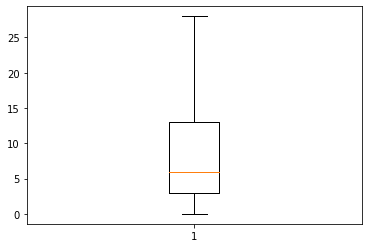

In [24]:
import matplotlib.pyplot as plt

plt.boxplot(l_com, showfliers=False)

plt.show()

In [25]:
l_code = []
for index, row in df_train.iterrows():
    l_code.append(len(row['code_token']))
print(f"Mean = {np.mean(l_code)}")
print(f"Median = {np.median(l_code)}")
print(f"Max = {np.max(l_code)}")



Mean = 156.7234
Median = 80.0
Max = 5554


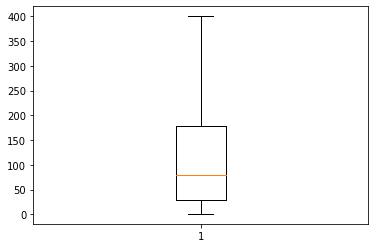

In [26]:
import matplotlib.pyplot as plt

plt.boxplot(l_code, showfliers=False)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


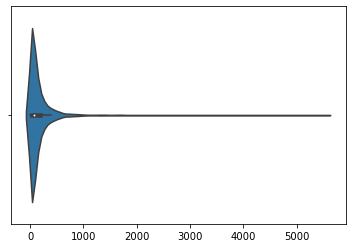

In [27]:
import seaborn as sns

ax = sns.violinplot(l_code, showextrema=False)

In [62]:
def encode_sentence(tokenized, vocab2index, N=25):
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [29]:
def encode_code(tokenized, vocab2index, N=400):
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [63]:
df_train['comment_vec'] = df_train['comment_token'].apply(lambda x: np.array(encode_sentence(x,vocab2index_com )))
df_train['code_vec'] = df_train['code_token'].apply(lambda x: np.array(encode_code(x,vocab2index_code )))

<ipython-input-63-de7353da255d>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  df_train['comment_vec'] = df_train['comment_token'].apply(lambda x: np.array(encode_sentence(x,vocab2index_com )))
<ipython-input-63-de7353da255d>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  df_train['code_vec'] = df_train['code_token'].apply(lambda x: np.array(encode_code(x,vocab2index_code )))


In [64]:
df_train.head()

code  \
1  struct _CameraFilesystem {\n\tCameraFilesystem...   
2  struct _CameraWidget {\n\tCameraWidgetType typ...   
4  \tchar error[2048];\t/**< Internal kept error ...   
5  \tstruct _GPPortInfo info;\t/**< Internal port...   
6  \tGPPortOperations *ops;\t/**< Internal port o...   

                                             comment  \
1  The internals of the #CameraFilesystem are onl...   
2  CameraWidget: The internals of the #CameraWidg...   
4                       Internal kept error message.   
5            Internal port information of this port.   
6                          Internal port operations.   

                                       comment_token  \
1  [internal, camerafilesystem, visible, access, ...   
2  [camerawidget, internal, camerawidget, visible...   
4                         [internal, error, message]   
5                [internal, port, information, port]   
6                        [internal, port, operation]   

                                          code_token  \
1  [struct TokenType.KEYWORD, _ TokenType.SPECIAL...   
2  [struct TokenType.KEYWORD, _ TokenType.SPECIAL...   
4  [char TokenType.KEYWORD, error TokenType.KEYWO...   
5  [struct TokenType.KEYWORD, _ TokenType.SPECIAL...   
6  [GPPortOperations TokenType.IDENTIFIER, * Toke...   

                                         comment_vec  \
1  [[2, 3, 4, 5, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  [[9, 2, 9, 4, 5, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0,...   
4  [[2, 10, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
5  [[2, 12, 13, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
6  [[2, 12, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                            code_vec  
1  [[2, 3, 4, 5, 1, 6, 7, 8, 9, 6, 1, 8, 9, 6, 1,...  
2  [[2, 3, 29, 5, 30, 31, 8, 32, 33, 34, 35, 36, ...  
4  [[32, 58, 34, 59, 36, 8, 41, 42, 0, 0, 0, 0, 0...  
5  [[2, 3, 60, 37, 8, 41, 42, 0, 0, 0, 0, 0, 0, 0...  
6  [[61, 6, 62, 8, 41, 42, 0, 0, 0, 0, 0, 0, 0, 0...

In [32]:
code = []
comment = []
for index,row in df_train.iterrows():
    code.append((row['code_vec'])[0])
    comment.append((row['comment_vec'])[0])

In [33]:
code_len = np.array(code[0].shape)
comment_len = np.array(comment[0].shape)

In [118]:
class SeqEncoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, n_layers=1):
        super(SeqEncoder, self).__init__()
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=0)
        self.lstm = nn.LSTM(emb_size, hidden_size, batch_first=True, bidirectional=True)
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)
        nn.init.constant_(self.embedding.weight[0], 0)
        for name, param in self.lstm.named_parameters():
            if 'weight' in name or 'bias' in name: 
                param.data.uniform_(-0.1, 0.1)

    def forward(self, inputs, input_lens=None): 
        '''
        input_lens: [batch_size]
        '''
        
        print(inputs)
        print(inputs.size())
        
        batch_size, seq_len=inputs.size()
        inputs = self.embedding(inputs)  # input: [batch_sz x seq_len]  embedded: [batch_sz x seq_len x emb_sz]
        inputs = F.dropout(inputs, 0.25, self.training)
        
        #if input_lens is not None:# sort and pack sequence 
        #    input_lens_sorted, indices = input_lens.sort(descending=True)
        #    inputs_sorted = inputs.index_select(0, indices)        
        #    inputs = pack_padded_sequence(inputs_sorted, input_lens_sorted.data.tolist(), batch_first=True)
            
        hids, (h_n, c_n) = self.lstm(inputs)  
        
        #if input_lens is not None: # reorder and pad
        #    _, inv_indices = indices.sort()
        #    hids, lens = pad_packed_sequence(hids, batch_first=True) # hids:[batch_size x seq_len x (n_dir*hid_sz)](biRNN)
        #    hids = F.dropout(hids, p=0.25, training=self.training)
        #    hids = hids.index_select(0, inv_indices)
        #    h_n = h_n.index_select(1, inv_indices)
        h_n = h_n.view(self.n_layers, 2, batch_size, self.hidden_size) #[n_layers x n_dirs x batch_sz x hid_sz]
        h_n = h_n[-1] 
        encoding3 = torch.cat((h_n[0], h_n[1]), dim=1)
        return encoding3 

In [119]:
class BOWEncoder(nn.Module):
  
    def __init__(self, vocab_size, emb_size, hidden_size):
        super(BOWEncoder, self).__init__()
        self.emb_size=emb_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size)
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)
        nn.init.constant_(self.embedding.weight[0], 0)
        
    def forward(self, input, input_len=None):
        batch_size, seq_len =input.size()
        embedded = self.embedding(input)  
        embedded= F.dropout(embedded, 0.25, self.training) 
        maxpooling = nn.MaxPool1d(kernel_size = seq_len, stride=seq_len)
        output_pool = maxpooling(embedded.transpose(1,2)).squeeze(2) 
        encoding = output_pool
        return encoding

In [120]:
class JointEmbedder(nn.Module):

    def __init__(self):
        super(JointEmbedder, self).__init__()
        self.margin = 1
               
        
        self.code_encoder=BOWEncoder(25200,512,512)
        self.comment_encoder=SeqEncoder(3500,512,1024)

        
        self.w_code = nn.Linear(512, 512)
        self.w_comment = nn.Linear(2*1024, 512)
        
        self.init_weights()
        
    def init_weights(self):# Initialize Linear Weight 
        for m in [self.w_code]:        
            m.weight.data.uniform_(-0.1, 0.1)#nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0.) 
            
    def code_encoding(self, code_tokens, code_len):
        code_repr=self.code_encoder(code_tokens, code_len)
        code_repr = self.w_code(code_repr)
        return code_repr
        
    def comment_encoding(self, comment, comment_len):
        comment_repr=self.comment_encoder(comment, comment_len)
        comment_repr=self.w_comment(comment_repr)
        return comment_repr
    
    def similarity(self, code_vec, comment_vec):
   
            return F.cosine_similarity(code_vec, comment_vec)
      
    
    def forward(self, code, code_len, comment_anchor, comment_anchor_len, comment_neg, comment_neg_len):
        batch_size=code.size(0)
        code_repr=self.code_encoding(code, code_len)
        comment_anchor_repr=self.comment_encoding(comment_anchor, comment_anchor_len)
        comment_neg_repr=self.comment_encoding(comment_neg, comment_neg_len)
    
        anchor_sim = self.similarity(code_repr, comment_anchor_repr)
        neg_sim = self.similarity(code_repr, comment_neg_repr) # [batch_sz x 1]
        
        #loss=(self.margin-anchor_sim+neg_sim).clamp(min=1e-6).mean()
        loss=(self.margin-anchor_sim+neg_sim).mean()
        
        return loss

In [121]:
model = JointEmbedder()


In [122]:
testcode = torch.from_numpy(np.array(code[3822:3823]))
testcomm = torch.from_numpy(np.array(comment[2822:2823]))
testnegcomm = torch.from_numpy(np.array(comment[12:13]))

In [123]:
model(testcode,code_len,testcomm,comment_len,testnegcomm,comment_len)

tensor([[ 414, 1902, 1880,  666, 1902,   18,   20,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], dtype=torch.int32)
torch.Size([1, 25])
tensor([[ 2, 27, 28, 29,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0]], dtype=torch.int32)
torch.Size([1, 25])


tensor(0.9952, grad_fn=<MeanBackward0>)

In [124]:
def train(data_loader):
    #optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)        
    #scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,num_training_steps=len(data_loader)*epochs)
    optimizer = torch.optim.Adam(model.parameters())
    n_iters = len(data_loader)
    for epoch in range(1): 
       
        losses=[]
        i = 0
        for batch in data_loader:
            
            model.train()
            
            code,code_len,good,good_len,bad,bad_len = batch
            code = code.squeeze(dim=1).to(device)
            code_len = code_len.squeeze(dim=1).to(device)
            good = good.squeeze(dim=1).to(device)
            good_len = good_len.squeeze(dim=1).to(device)
            bad = bad.squeeze(dim=1).to(device)
            bad_len = bad_len.squeeze(dim=1).to(device)
            
            loss = model(code,code_len,good,good_len,bad,bad_len)
            
            #batch_gpu = [tensor.to(device) for tensor in batch]
            #loss = model(*batch_gpu)
            #loss = model(*batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #scheduler.step()
            model.zero_grad()
            losses.append(loss.item())
            print(loss.item())

In [125]:
class CodeSearchDataset(Dataset):
    def __init__(self, code, code_len, comment=None, comment_len=None):
        
        self.code = code
        self.code_len = code_len
        self.data_len = len(code)
        self.comment = comment
        self.comment_len = comment_len
        
    def __getitem__(self, idx):
        
        cd = torch.from_numpy(self.code[idx])
        cd = cd.unsqueeze(dim=0)
        cd_len = torch.from_numpy(self.code_len)
        
        #if self.training:
        good_desc = torch.from_numpy(self.comment[idx])
        good_desc = good_desc.unsqueeze(dim=0)
        good_desc_len = torch.from_numpy(self.comment_len)
            
        rand_idx=random.randint(0, self.data_len-1)
            
        bad_desc = torch.from_numpy(self.comment[rand_idx])
        bad_desc = bad_desc.unsqueeze(dim=0)
        bad_desc_len = torch.from_numpy(self.comment_len)
            
        return cd, cd_len, good_desc, good_desc_len, bad_desc, bad_desc_len
        #return cd, code_len
    
    def __len__(self):
        return(self.data_len)

In [126]:
dataset = CodeSearchDataset(code, code_len, comment, comment_len)

In [127]:
data_loader = DataLoader(dataset, batch_size=4, collate_fn=None)

In [128]:
model.to(device)

JointEmbedder(
  (code_encoder): BOWEncoder(
    (embedding): Embedding(25200, 512)
  )
  (comment_encoder): SeqEncoder(
    (embedding): Embedding(3500, 512, padding_idx=0)
    (lstm): LSTM(512, 1024, batch_first=True, bidirectional=True)
  )
  (w_code): Linear(in_features=512, out_features=512, bias=True)
  (w_comment): Linear(in_features=2048, out_features=512, bias=True)
)

In [129]:
train(data_loader)

tensor([[ 2,  3,  4,  5,  6,  7,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0],
        [ 9,  2,  9,  4,  5,  6,  7,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0],
        [ 2, 10, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0],
        [ 2, 12, 13, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 771,   22, 1830, 1879,  275,  396,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1019,    7,   33,  189,  154,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2760,  107,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    

tensor([[204,  73, 176,  22, 205, 206, 207, 127,  22, 205, 206, 207, 208, 100,
          10, 115, 209, 127, 159,  10, 128,   0,   0,   0,   0],
        [  1,  73, 176, 100, 210,  10, 211,  73, 212,  80,  35, 155, 213,  19,
         126, 214, 215,  73, 216,  10, 217,  73, 155, 176, 218],
        [  1,  70, 225,   1, 214, 226, 227, 228, 214, 229, 230, 231, 225, 214,
         232, 230, 158, 231, 225, 158, 214, 232,  70,  68, 233],
        [240, 241, 227, 228, 214, 229,  45,   7,  77, 127, 128,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 526,  494,  526,  295,   22,  750,   76,  118,   20,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 3075,  894, 1927, 3075, 1262,   77,  191,  415,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
    

0.8040258884429932
tensor([[67, 68, 69, 70, 71, 72, 73, 74, 49, 75, 76, 77, 68, 60,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0],
        [78, 79, 80, 77, 79, 73, 81, 82, 83, 79, 84, 73, 85, 77, 79, 80,  0,  0,
          0,  0,  0,  0,  0,  0,  0],
        [78, 79, 80, 77, 79, 73, 81, 82, 83, 79, 84, 73, 85, 77, 79, 80,  0,  0,
          0,  0,  0,  0,  0,  0,  0],
        [67, 68, 69, 70, 71, 72, 73, 74, 49, 75, 76, 77, 68, 60,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 554, 1044,  714,  705, 3183,  311, 3257,   89,  142, 3258,  118,   74,
         1641,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154,   52, 3381,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   7, 2843, 2866,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           

tensor([[112,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [112,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [112,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [112,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 394, 1890,   83,   79,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  191,   10,  101, 3098,   10,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
    

tensor([[379, 379,  19,  19, 110, 236, 236,  19,  19, 188, 380,   1,  68, 146,
         110,  71,  11,   6,   1, 147,   0,   0,   0,   0,   0],
        [  2, 378, 381, 128,  68,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  2, 378,  68, 381, 128,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 77,  33,  68, 382,  10, 128,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 295,  140,   69,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2101, 1808,   22,   20, 2101, 1808,  154,  303, 1808,  230, 2134,  246,
         1019,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
    

tensor([[67, 68, 69, 70, 71, 72, 73, 74, 49, 75, 76, 77, 68, 60,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0],
        [78, 79, 80, 77, 79, 73, 81, 82, 83, 79, 84, 73, 85, 77, 79, 80,  0,  0,
          0,  0,  0,  0,  0,  0,  0],
        [67, 68, 69, 70, 71, 72, 73, 74, 49, 75, 76, 77, 68, 60,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0],
        [78, 79, 80, 77, 79, 73, 81, 82, 83, 79, 84, 73, 85, 77, 79, 80,  0,  0,
          0,  0,  0,  0,  0,  0,  0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 188,  750,  705,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2051,  395,  106,  404,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 1859,    1,    1,    1,  579,  664,  201,    0,    0,    0,    0,
            0,    0,    0,    

-0.0720546692609787
tensor([[67, 68, 69, 70, 71, 72, 73, 74, 49, 75, 76, 77, 68, 60,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0],
        [78, 79, 80, 77, 79, 73, 81, 82, 83, 79, 84, 73, 85, 77, 79, 80,  0,  0,
          0,  0,  0,  0,  0,  0,  0],
        [86, 73,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0],
        [52,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  77,  103,  191,  415,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1331,  716,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 685,  484,  658,    6,  685,  723,  243,    0,    0,    0,    0,    0,
          

1.0000176429748535
tensor([[  1, 452, 453,  17, 375,  17, 375,  22,  19, 488, 375,  17, 118,  28,
          19, 374, 306, 375,  77,  33, 469, 128,   0,   0,   0],
        [  1, 452, 453,  17, 375,  17, 375,  22,  19, 488, 236,  22, 489,  77,
         236, 375, 375,  17, 118,  28,  19, 374, 306, 375,  77],
        [  1, 452, 453,  17, 375,  17, 490,  22,   1, 375,  17, 118,  28,  19,
         374, 306, 375,  77,  33, 469, 128,   0,   0,   0,   0],
        [  1, 452, 453,  17, 375,  17, 107, 491, 106, 375,  17, 118, 106,  19,
         107, 491,  77,  33, 469, 128,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 484,  481,  116, 1333,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154, 1894,  395,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
 

tensor([[  1, 214, 409, 562, 324, 329, 128, 452, 453,  77,  33, 469, 128, 275,
         125,  19,  22,  19,  22, 275, 459, 236, 236,  19,  77],
        [  1, 214,   1,  52, 290, 567, 568, 452, 453,  77,  33, 469, 128,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  1, 214, 319,  52, 290, 567, 568, 452, 453,  77,  33, 469, 128,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  1, 214, 544,  52, 290, 567, 568, 452, 453,  77,  33, 469, 128,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 834,  990,  547,    1,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 596,   19, 1119,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
    

tensor([[  1,  73, 375, 176,  19, 242,  73, 173, 427, 592, 283, 594, 286, 595,
         429, 295, 173, 242,  73, 255,  12,   6, 591,  77, 127],
        [  1,  73, 375, 176,  74, 283, 429, 295, 283, 173,  19,  70,  70, 283,
         255,  12,   6, 591, 596, 592,  13,  74, 429, 295, 173],
        [  1,  73, 375, 176, 320, 598,  73,  77, 598,  70, 582,  10, 599,  70,
         391,   1,  70,   0,   0,   0,   0,   0,   0,   0,   0],
        [  1,  73, 162, 162, 159, 190,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,   22,  167,  913, 2747, 1342,  167,  913,   77,  191,  415,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 2285,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
    

tensor([[78, 79, 80, 77, 79, 73, 81, 82, 83, 79, 84, 73, 85, 77, 79, 80,  0,  0,
          0,  0,  0,  0,  0,  0,  0],
        [86, 73,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0],
        [67, 68, 69, 70, 71, 72, 73, 74, 49, 75, 76, 77, 68, 60,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0],
        [78, 79, 80, 77, 79, 73, 81, 82, 83, 79, 84, 73, 85, 77, 79, 80,  0,  0,
          0,  0,  0,  0,  0,  0,  0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 498,  375,  369,   19,    1,   72,  401, 1170,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 118,  577,  397, 1896,  118,   13,   27,   83,   77,  191, 1149,  415,
          383, 1830,   72, 1980,   20,  577, 1981, 1830,   18,   20,  646,  600,
          184],
        [3073,   81,  402, 1682,   77,  103,  191,  103,  415,    0,    0,    0,
            0,    0,    0,    

1.1981419324874878
tensor([[  1,  73, 383, 100,  10, 115, 383, 192,  73, 644, 211, 106, 159,  10,
         128, 191,  10, 582, 645, 195, 196,   0,   0,   0,   0],
        [  1,  73, 564, 100,  10, 115, 280, 646, 255, 295, 218,  73,  77, 280,
         646, 255, 295,  73,  10, 128,   0,   0,   0,   0,   0],
        [  1,  73, 383, 100,  10, 115, 383, 192, 118,  77,  10, 128, 190, 191,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  1,  73, 647, 407, 100,  10, 101, 647, 407,  73, 267, 151,  77,  10,
         128,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,   22, 2498,   20,  336,  143,  723,  183,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 952,  725, 1881,  645, 1902,   18,   20,   77,   33,  403,  649, 2026,
         2027,  848,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
 

tensor([[685,  11, 688,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [685, 564,  11,  20, 686, 138,   6, 687, 523,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [685, 298,  83,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 22, 569, 689, 690, 283, 691,  83,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 604,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 236,  140, 1073,   69,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
    

tensor([[488,   6, 488, 399,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [720,  79,  27,  74, 721, 236,   6, 722,   1, 304, 721,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  1,   1, 723,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [188, 290, 712, 324,  74, 658,   7, 185, 724, 188,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1532, 1676,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 189,  321,  154, 2631,  321,    7, 2632,  360,  321,  451,  321,  240,
          129,  550,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
    

1.001769781112671
tensor([[ 90, 410, 750, 140, 386,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 90, 750, 410, 140, 386,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [272, 759, 706,  33, 605, 760,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [272, 402, 706,  70,  21,   1, 605, 760,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 535,   14,   94,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1890,   60, 1532,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
  

1.0021196603775024
tensor([[779, 302, 751, 685, 723,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [685, 796, 757, 771,  17, 840, 588,   1, 589, 158, 839,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [841, 143, 410,  79, 833,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [189,  83, 143, 410,  79, 324, 833,   1,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1, 3083,  375,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  191,   10,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
 

tensor([[870, 285, 397, 438,   6, 328,   1, 285, 328, 871, 872, 873, 140,   1,
         874, 328, 875, 140,  56,   0,   0,   0,   0,   0,   0],
        [284, 285, 697, 876, 877, 688, 146,   1, 876,   6,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [655, 878,   1,   1, 879, 141, 369,  19, 369, 594, 285,  60,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [461,   1, 404, 357,   1,  33, 383, 435,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 154,  650,   74,  212,  105,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 127,   13,  107,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
    

tensor([[920, 307,  77, 755,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  1, 306, 373, 311, 375, 236, 140, 307,  77,  22, 306, 307, 306, 307,
         257, 140,  33, 625,   0,   0,   0,   0,   0,   0,   0],
        [ 55, 272, 335, 333, 913,   1, 513, 921,  79,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 55, 272, 333, 236, 913,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 154, 1676,  324,  348,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1390,  617, 1677,  592, 1002,  716,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
    

tensor([[947, 714, 655, 355, 661,   7, 948, 708, 100,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [949, 714, 655, 355, 661,   7, 948, 708, 100,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [950, 951, 950, 182, 714, 655, 355, 661,   7, 948, 708, 100,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [855, 952, 307, 569, 429, 727, 953, 661, 913, 876, 954, 290, 283, 661,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1676,  329,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 242,   19,  726,  169,  712,  728,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
    

tensor([[981, 985, 839, 986,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [981, 154, 985, 839, 986,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [981, 341,  70, 982,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [383, 540,  27, 242, 723,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 106, 1917, 1798, 1019,   22,   20, 1019,  371,  106,   19,  106, 1019,
          371,  702, 1797, 2182,  702,  388,  106,   19, 1798, 1019,  371,  245,
         1797],
        [3419,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
    

0.9991932511329651
tensor([[ 414,  395,  348,  426,  313,  373, 1013,   77, 1014,  313, 1013,  242,
          414,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 215, 1015,  771,  771,  189,  724,   56,  320,   56,  339,  771, 1016,
          771,  724,  304,  994,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   63,   19,  774, 1017,  102,  864,  737,  242, 1018,    1,  304,
          994,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154,  954,  301,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 210,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2235,    6, 2236,    5,  

0.9904423952102661
tensor([[ 200,  702,  647,  523,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 450,  797,  714,  714, 1043,    5,  797, 1044,    7,    5,  647,  714,
          525,  714,    6,   11, 1045,   94,  771,  551,  661,  263,  714,  100,
            0],
        [ 150,  776,  283,  708,  604,  341,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 324,    7,  714,  100,  708,  793,    5,    1,    7,  355,    5,  797,
         1044,  128,    1,  911,    5,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 132,  592,  569,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 106,  125,  592,   69,  

tensor([[ 562,   68,  440, 1061, 1062,  105, 1063,  252,  891,   68,  440, 1062,
         1064,  182,  597,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 140,   68,  382,  541, 1065,  629,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 230,  205,  141,  136,  382,  541, 1065,  629,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 173, 1065, 1048,  230,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1867,  214,  217,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154, 2042,  540, 2042,  377, 2121,    0,   

tensor([[230,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [230,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [230,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [230,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1193, 1194, 1193, 1194,  452, 1193,  562, 1195,   74,  118,  977,  452,
         1194, 1188, 1196,   74,  118,  977,    0,    0,    0,    0,    0,    0,
            0],
        [1118,  921,  103, 1798,  207,  243, 1902,   18,   20, 1798,  207,  366,
          207,  267,  921,   82, 1805,  704, 1806, 1252,  397,   96,    0,    0,
            0],
    

0.9942070245742798
tensor([[  47, 1073,  606,  605, 1065, 1075, 1075, 1076,  605, 1073,  606, 1077,
         1078,  606,    1,  432,  592,  688,    0,    0,    0,    0,    0,    0,
            0],
        [ 404, 1079,  298,  422, 1065,  529,  137,  529,  278,  621, 1079,  298,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 404, 1080, 1081,   83,  422, 1080, 1081,  529, 1080, 1081, 1082,  587,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 404, 1080, 1081,   83,   33,  422, 1080, 1081,  529, 1080, 1081,   33,
          605, 1056,  429,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 295, 1119,  604,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154, 1312,  617,    6,  

1.0002384185791016
tensor([[ 440,  377,  332, 1099,  348,  377,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 440, 1100,  377,  332, 1099,  348,  377, 1100,  377,  332,  464,   33,
          625,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 496,  377,  332, 1099,  348,  377,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1087,  348,   55,  236,  920,  333, 1089, 1090,  290, 1100,  348,  129,
          148,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1766,   79,  274,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2628, 2629,  110,   11,  

tensor([[ 132,  639,  395,   68,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1048,  404,  402,   33,   29,  639,  302,  404,   25,  267,  304, 1079,
          639,  600,  402, 1118,   33,   77,    7,    0,    0,    0,    0,    0,
            0],
        [1117,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 132,  295, 1119,  629,  596,  605,  596,   94,   21,   33, 1120,  596,
          592,  688,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  33,  596,  424, 2674, 3425,   19,   74,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2394, 2323,  167, 2320,   77, 2321,  114,  1

tensor([[ 154,    1,    7, 1061,    6,    1,  180,   19, 1145,    1,  232,  114,
            7,  295,    7,  129, 1146,  313,  103, 1147, 1146,  531,  103,    1,
         1148],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 416,  607,  416,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 320,  321, 1020,  661,  658,  444,  575, 2627,  839,  328,  661,  321,
          579,  129,  321, 2634, 2635,  792, 1114,  402,  451,    0,    0,    0,
            0],
        [ 106,    1,    0,    0,    0,    0,    0,   

0.9439848065376282
tensor([[321,  56, 726, 588,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [301, 395,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [301, 867,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [697,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 697,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 612,  107,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
 

1.0275237560272217
tensor([[ 604,  101,   77,  410,  526, 1200,  140,   21,  101,  295,  118,    6,
         1201,  101,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1202,  267,   56,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 427,  452,  118,  118,   17,   77, 1199,  452,   19,   19,  242,  561,
          101,  295,  140,  452,  173,  173,  140,   19,  242,  561,  101,  295,
           77],
        [ 427,   19,  452,  118,  118,   17,   77, 1199,  452,   19,   69,  211,
           19,  561,  101,  154,  140,   19,  101,  101,  211,  452,  173,  295,
          140]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[2811, 1414,    1,  921,    6, 2811,  118,    6,  290,   52,  137,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 526,  494,  526,  295,  

1.0015621185302734
tensor([[ 352, 1212,  266, 1168, 1213,  603,   48,  783,  603, 1214, 1215,  164,
         1215, 1216, 1213, 1200,    1,  603,    6, 1217,  274,  604,  222,  274,
          604],
        [1229,   48, 1230,  107, 1081,  842,  357,  128,  758,  357,  128,  148,
         1230,  107,  440,  357,  800, 1231, 1232, 1233,  799,  199,  799, 1234,
         1235],
        [1229,   48, 1230,  107, 1081,  842,  357,  128,  758,  357,  128,  148,
         1230,  107,  440,  357,  800, 1231, 1232, 1233,  799,  199,  799, 1234,
         1235],
        [ 130,  153,  315,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,   22,  379, 1331, 1014,  402,    6,   77,  191,  103,   10,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 402,  154, 3256,  120,  

tensor([[ 130,  153,  315,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  19, 1271,  658,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  19, 1271,  658,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 192,   94,  592,  658,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  32,  205,   33,  332,   22,  206,  884,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154, 1081, 1062,  105, 1097, 1064, 1063,  1

1.0034799575805664
tensor([[1327, 1328,    7,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1327,    1,    7,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1327,  306,  383, 1329, 1330,  647,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1327, 1329, 1328,    7,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 242,   70,   19,  750,  523, 1994, 1902,   18,   20,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 2341,    0,    0,  

tensor([[ 129,   83,    1,   79,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 579, 1326, 1170,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1256,  221, 1300,   47, 1301,   56, 1302, 1303,  188,  649, 1239,   47,
         1304,  224,  540,  706,  435, 1305,   57,  384,  355, 1306,   64, 1307,
           47],
        [1256,  221, 1300,   47, 1301,   56, 1302, 1303,  188,  649, 1239,   47,
         1304,  224,  540,  706,  435, 1305,   57,  384,  355, 1306,   64, 1307,
           47]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 307, 1404, 1405,   40,  307, 1012,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 964,   68, 1750,   69, 1569, 3281,   48,   

tensor([[335, 306, 307,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [335, 306, 307,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [335, 307, 306, 294, 283, 621,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [335, 306, 307,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 242, 2050,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 769,  402,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
    

0.7594163417816162
tensor([[  77,  658, 1393,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  658,   10,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 210, 1376,  407,    1,  254,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 210, 1376,  407,  254,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 1146, 1884, 1523,  

tensor([[1256,  221, 1300,   47, 1301,   56, 1302, 1303,  188,  649, 1239,   47,
         1304,  224,  540,  706,  435, 1305,   57,  384,  355, 1306,   64, 1307,
           47],
        [ 579, 1326, 1170,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1256,  221, 1300,   47, 1301,   56, 1302, 1303,  188,  649, 1239,   47,
         1304,  224,  540,  706,  435, 1305,   57,  384,  355, 1306,   64, 1307,
           47],
        [1256,  221, 1300,   47, 1301,   56, 1302, 1303,  188,  649, 1239,   47,
         1304,  224,  540,  706,  435, 1305,   57,  384,  355, 1306,   64, 1307,
           47]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,  321,  658,  335,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1896,   10,  163,   22, 1896,  118,  132, 18

tensor([[1256,  221, 1300,   47, 1301,   56, 1302, 1303,  188,  649, 1239,   47,
         1304,  224,  540,  706,  435, 1305,   57,  384,  355, 1306,   64, 1307,
           47],
        [ 634,  990,   74,   77, 1396, 1397,    1,   68,  484,   77,  182,  484,
          334, 1419,    7,   17,   10,  103,    1,  210,   77,   68,    0,    0,
            0],
        [ 634,  990,   74,   77, 1397,   68,  484,  514,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  86, 1366, 1420, 1421, 1327,   16,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 127,   13,  107,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154, 3374, 1833,  101,  127,  289,    0,   

tensor([[ 743,  953,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 518, 1431,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1432, 1433,  412,    1,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  77,  191,   10,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 300, 1553,  321,    0,    0,    0,    0,   

tensor([[   1,   68, 1447,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   68,  771,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1096,   55,    6,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 634,  407,    1,    1,    6,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 656,  623,  921, 2033, 1795,  575, 1902,   18,   20,   17,  164, 1007,
          706, 1795, 1830,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 839,  733, 2938, 1865,    7,    0,    0,   

tensor([[  77,  127, 1464,    1,  336,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1468,  151,   11,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 697,  208,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 661,  288,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 211, 1894, 1019,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 242,   70,   19,  750,  523, 1994, 1902,   

0.6859633922576904
tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1207,  129, 1209,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1207, 1486,   55,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 394,  835,  989, 1437, 1433,   83,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 308, 1798,   13,   22,  

0.9473426938056946
tensor([[1283,  107,  130,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  335,  107,   17,  357,  214,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  107,   22,  887,   17,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  607,  107,  977,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,  137, 1156, 1075, 1075,  402,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 751, 1881, 1436,  600, 1

tensor([[ 284, 1496,    1,    1,  488, 1497, 1498,   93,    1,  300, 1498,   96,
         1499, 1177,  488, 1500,    1,  386, 1498, 1501, 1149,   77,   33,  241,
         1191],
        [  77,  290,  116, 1333,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1283,  333,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  86,  201,  990,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  77,  191,  415,   10,  101,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1894,  315,  395,  978,    0,    0,    0,   

tensor([[1429,  630,  298,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 404,  128,  557,  128,   21,  298,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  615,  625,  128,  605,  128,  148, 1449,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77, 1505,  128,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1, 1633,   77,   74,  341,   14,  123, 1333,  182,  123,   45,    1,
           77, 1333,  457, 1650,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 2285,  132,  647,  395, 2285,   77,   

            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
0.7505288124084473
tensor([[ 308,  332,  205,  969,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 308, 1509,  907,  969,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 308, 1509,  205,  969,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 335,  232,  298,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1896, 1898,  600,   22, 1896,  118,  756,  296, 1899,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,  

1.0167078971862793
tensor([[ 640, 1487,  561,  208,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  17,  706,  664,  232,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1392,    1,  664,  201,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1209,  989, 1516, 1517, 1518,  758,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 118, 1982,  397, 1896,  118,   13,   27, 1896, 1979, 1983,   82,  245,
         1896,  118,  216, 1984,  915,  321,   82,  189,  307,    0,    0,    0,
            0],
        [ 230,    0,    0,    0,  

tensor([[  77,  607,  587,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  607,   71,   21, 1173,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  90, 1504,   68,    1,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  90, 1504,   68,    1,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  77, 3245,  411,  723,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 132,  592,  733, 2938, 1865,    7,    0,   

            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
0.2688171863555908
tensor([[1331,  700,  300,  700, 1475,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 188,  290,  700,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 300,  700, 1547,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154, 1020,  700,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1087, 1081,   55,  236,  920,  333, 1089, 1090,  290,  464,  129,  148,
            0,    0,    0,    0,    0,    0,    0,    0,  

1.0000301599502563
tensor([[ 154,   68,   33,  201, 1433,  173,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   68,  201, 1433,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154, 1183,  295,   33,  201, 1433,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154,  205,   33,  201, 1433,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  70,  285, 1997, 1902,   18,   20,   70,  491,  127,   10,  464,   70,
          491, 1998,  464,  705,   69,  776,   19,    0,    0,    0,    0,    0,
            0],
        [ 188,  290,  201,    0,  

tensor([[  63,    1,   33,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 129, 1333,   55,   79,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 188,   55,  201,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 188,  990,  201,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1532,  603,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1515, 1436,    0,    0,    0,    0,    0,   

0.9998432397842407
tensor([[   1, 1620,   69, 1621, 1176, 1521, 1619,   65,    1, 1294,  188,  290,
         1566,  353,  182,  150, 1248,   69, 1623, 1248,  353,   77, 1566,  272,
          310],
        [   1,  498,   69, 1571,  290,   69,  188,  290, 1209, 1566, 1624,   57,
           69,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 1566, 1622,  137,   69,  137,   69, 1625,  188,  138,    6, 1626,
          968,  182,    1, 1598,  137, 1627, 1129,  366, 1628, 1598,  137,   69,
          154],
        [1626, 1566,  290, 1622,  137,    1, 1598,  137,  154, 1622,  137,   69,
          154, 1622,  137,   69,  553,  290,  137,  221,  140,  297, 1598,  137,
          182]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1252,  941, 2112,   81,   22,   20, 1252,  941, 2112,  579,  154, 2113,
           20,  230, 2114,  246, 1019, 1773,  154,  921,    0,    0,    0,    0,
            0],
        [ 404,  321,  328,  340,  

tensor([[1665, 1571,  290, 1621, 1571,  290, 1621,    1,  551,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1665,   22, 1571,   22, 1571, 1668, 1571,    8,   51, 1571, 1668, 1207,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1665,   68,  233, 1207,  263,  780, 1075, 1668,   68,  710,    1,  294,
            1, 1207,   68,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1665, 1601, 1665,   68,   77, 1669,  306,   68,   84, 1665,   77,   68,
         1670,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1, 2260,   74, 2262,   52,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 383, 2168,  526,  306, 2168,  667,  540,  5

tensor([[   1,  284,  138, 1597, 1333,    1, 1634, 1713,   72,  138, 1597, 1333,
            1,  352, 1604, 1448,  488, 1713, 1604,  352, 1333,  358,    0,    0,
            0],
        [   1, 1714,  404, 1509,  575,    1, 1391, 1458, 1391,  138,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   18,   27, 1714, 1139,    1,  873,  332,  333,   89,   79,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   79, 1093, 1170,   74,  290, 1170,   77,   22,  290, 1170,  873,
           79, 1093,  290, 1170,   79,  182,    8,    1,   14,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 308,    1,  603,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 383,  526, 2169,  751,  526,    6, 1405,  4

tensor([[   1, 1729, 1331, 1729,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 1729, 1168, 1360, 1595, 1168, 1360, 1732, 1360,  114, 1168,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 1729,  295,  297,  920, 1360, 1595,  295,  297,  920, 1360, 1732,
         1087, 1360,  114, 1500,   33,  920, 1360, 1149,   33,   53,    0,    0,
            0],
        [   1, 1729, 1729,  154,  488, 1733,  488,  483,  488,  154,  297,   21,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 188,  290, 1600,   65,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 335, 1987, 1902,   18,   20,    0,    0,   

tensor([[   1, 1759, 1761,  663,  701,  663,  435, 1762,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1763, 1759,  150,  607, 1757,  435, 1569, 1758,  154,  329,  435, 1761,
          663,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 1764,   77,  378,  619,  382, 1764,   77,   68,  335,   77,   33,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,   33,  290, 1765,   27,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,  523,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1532,  603,    0,    0,    0,    0,    0,   

0.9965991377830505
tensor([[1331, 1786,  116,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 484, 1521, 1787,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 440,  290,  407,   33,  842, 1786,  116,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 189, 1333,  116,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 464, 1097, 1953,  176, 2921, 2920, 1953, 1960,  348,  603, 2086,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  33,   79,    0,    0,  

0.9970440864562988
tensor([[ 661,   79, 1436,   47,    8,   55,   21,   79,   22,   47,    7,  547,
           83, 1664,  182,   22,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 594, 1414,  407,   22,  205,   33,  332,    6,  594,  407,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 594, 1414,  407,   22,   33,  332,   22,    6,   22,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 594, 1414,  407,   68,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 383,  638,  375,  640,  641,  629,  404,  545,  596,  545,  639,  257,
          298,    6,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 750,   76, 1020,  750,  

0.9996296167373657
tensor([[189,  33, 872, 569,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [211,  33, 872, 569, 189, 569,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [129,  33, 873, 569,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [189,  33, 873, 569,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 404,   65,   77,  607,   65,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 383, 1808, 1433,   27,   21,  201,    5, 1567,  128,  154, 1808,  201,
           27, 1962,  751,    0,    0,    0,    0,    0,    0,    0,    0,    0,
 

tensor([[  40,   33,  407, 1793,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 484,  295,   83, 1793,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1193, 1194, 1193, 1194,  452, 1193,  562, 1195,   74,  118,  977,  452,
         1194, 1188, 1196,   74,  118,  977,    0,    0,    0,    0,    0,    0,
            0],
        [1197,  452, 1193,  562, 1195,  118,  977,  452, 1194, 1188, 1196,  118,
          977,  452, 1197,  255,  295,  118,  977, 1008,  182,   77,    7,   77,
           22]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,   77,  191,  414, 1516,  909,    1,  388,   10,  101, 3098,   10,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   0,    0,    0,    0,    0,    0,    0,   

tensor([[1797,  263,    5, 1804, 1019,   22,   20, 1797,  702,    5, 1804,   76,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 245,  263,    5, 1804, 1019,   22,   20,  245,  702,    6,    5, 1804,
           76,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1797,  263,    5, 1799,   22,   20, 1797,  702,    5, 1808,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1809,  263,    5, 1799,   22,   20,  245,  702,    6,    5, 1808,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1532,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   0,    0,    0,    0,    0,    0,    0,   

1.0007590055465698
tensor([[ 394, 1845,  603,  298,   22,   20,  394, 1019,   55,   21, 1845,  603,
          298,  154,   33,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 414,  744,  243,   22,   20,   55,  744,  243,  288,  295,  744,  243,
          288, 1846, 1019,  335,  288, 1545,  295,   81,   70,  243, 1847,  414,
           70],
        [ 769,  605,  839, 1814, 1837,   22,   20,   22, 1799, 1808,  211, 1808,
          132,  839, 1814,  315, 1814,  315,  605,  154,  605, 1814,  315,    0,
            0],
        [ 687, 1852,  243,  395,   22,   20,  308,   77,  132,  687, 1852,  243,
          395,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,  757,  375,   77,  191,  415,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1827, 1808,  605,  285,  

tensor([[ 245,  646,  702,   22,   20,  245,  646,  702,    6,    5, 1798, 1799,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154,  412,  207, 1838,  395,   22,   20,  607, 1252, 1839,  416,  941,
          154, 1839,  395,  528, 1020,  402, 1839, 1547,  118, 1843, 1844, 1240,
           49],
        [1859,  412,  207,  921,  395,   22,   20,  624,    6, 1252,  941, 1839,
          412,  207,  921, 1839,  395,  154,  207, 1258,  270, 1020,  607,  394,
         1839],
        [1488, 1798,  989, 1807,   22,   20,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 167,  913, 3177, 1139,  167,  913, 3177, 2803,  499, 3177,   77, 1378,
         3177,   10,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  51,  372,  345, 1436,  750,   76,  118,   

tensor([[  77,  575, 1873, 1874,   76,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 540, 1864, 1618, 1874,   14,  737,    5, 1864, 1618,  507, 1043,    6,
            7,    7,  737,    6, 1864,    7,  377, 1618,  451, 1618,  377, 1618,
          377],
        [ 977, 1864, 1618, 1875,    5,    7,    7,  737,    6, 1864,    7,  377,
         1618,  451, 1618,  377, 1618,  377,  295, 1618,  114,  398, 1618,  435,
            0],
        [ 245,  540, 1864, 1618,    6, 1618,  245,  426,  737,  617,  335,  188,
          427,   20, 1874,  100,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 242,   11,  150,  100,  210,  354,  355,  356,    6,   73,   82,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1797, 1799, 2088,   22,   20, 1797, 2088,  4

0.9924147129058838
tensor([[ 109,   76, 1869,    1, 1882,  335,  306,  307,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1019,  109,   76,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1883,  109,   76,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 242,  592,   19,   76,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 105,  306, 1323, 1591, 1384,   20,   74,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2043,  395, 2045,  404,  

0.9979547262191772
tensor([[  77,  132,  236,  379,   63,   19,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   8,  835,  307,   28,  379,   63,   19, 1890,   83, 1019, 1547, 1618,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  379,   63,   19,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 206,  395,  379,  901,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 188,   55,   21,  621,   79,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 1765,   27,  335, 1

tensor([[1118,  921,  103, 1798,  207,  243, 1902,   18,   20, 1798,  207,  366,
          207,  267,  921,   82, 1805,  704, 1806, 1252,  397,   96,    0,    0,
            0],
        [1049,  306,  725,  491,  569, 1902,   18,   20,    7,   77,   10,  346,
         1871, 1555, 1904,   24, 1905,  848, 1906, 1871,   77,  191, 1149,  415,
         1049],
        [1049,  306,  725,  491,  569, 1902,   18,   20,    7,   77,   10,  346,
         1871, 1555, 1904,   24, 1905,  848, 1906, 1871,   77,  191, 1149,  415,
         1049],
        [ 335, 1903, 1907, 1902,   18,   20,  335, 1881,  800,  725,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[2172,  714,  630, 2916,  341,  592,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 498,  716,  375,    0,    0,    0,    0,   

0.918757438659668
tensor([[  27,   21,  201,    5, 1567,  128,  404, 1798,  315,   77,  193,  600,
          515,  103,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 383,   70,  243,  603,   27,   21,  201,    5, 1567,  128,  620,  515,
          243,   70,  243, 1019,  394, 1904,   70,  243, 1019,  394,  744,  298,
           93],
        [1917,  324, 1019,   27,   21,  201,    5, 1567,  128, 1798,   13,   20,
         1798,   13, 1798, 1019, 1917, 1798,    0,    0,    0,    0,    0,    0,
            0],
        [ 324, 1019,   27,   21,  201,    5, 1567,  128, 1798,   13,   20, 1798,
           13, 1798, 1019, 1798,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1851, 1862, 1813,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  150,  607, 1252,  1

0.9750586152076721
tensor([[1954,  921, 1392,   27,   21,  201,    5, 1567,  128, 1837,  515, 1798,
          921,  154,  515,  132, 1798,  164, 1007,  290, 1824,  138,  751, 1819,
         1168],
        [1798,   29,   27,   21,  201,    5, 1567,  128, 1817, 1798, 1908, 1820,
          246, 1844,   29,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154, 1819, 1168, 1019,   27,   21,  201,    5, 1567,  128,  154, 1819,
         1168, 1881,  246, 1019,  921,  446,  774,  211,  164, 1007,   13,  118,
          127],
        [1681, 1820,  246,   29,   27,   21,  201,    5, 1567,  128, 1909, 1959,
         1820,  246,   29,  154, 1914, 1915,  230,  118,  246, 1019, 1612, 1830,
           29]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 295, 2958,  297,  311,   64,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 129,  140,  953,    0,  

tensor([[1917,  324, 1019,   27,   21,  201,    5, 1567,  128, 1798,   13,   20,
         1798,   13, 1798, 1019, 1917, 1798,    0,    0,    0,    0,    0,    0,
            0],
        [ 324, 1019,   27,   21,  201,    5, 1567,  128, 1798,   13,   20, 1798,
           13, 1798, 1019, 1798,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154,  921,  207,  395,   27,   21,  201,    5, 1567,  128,  607, 1252,
         1839,  416,  941, 1839,    7,  154, 1839,  395,  528, 1020,  402, 1547,
         1839],
        [  27,   21,  201,    5, 1567,  128,  105, 1908,  645,   56,  158,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 129,  578,   69, 1600,   63, 1066, 1598,   69,  721, 1561,    5,  185,
          841, 1360, 1601,  304,    6, 1579,   77,  205,   17, 1370,    1, 1600,
           20],
        [1073, 2161, 2216,    0,    0,    0,    0,   

0.6715759038925171
tensor([[ 383, 1808, 1433,   27,   21,  201,    5, 1567,  128,  154, 1808,  201,
           27, 1962,  751,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1827, 1808,  605,  285,   27,   21,  201,    5, 1567,  128,  211,  230,
          231, 1808, 1318,   33,  211, 1318,  230,  231, 1950,  285,  605,    0,
            0],
        [1740,  106, 1808,  285,   27,   21,  201,    5, 1567,  128, 1318,  230,
          231, 1808, 1734, 1318,  106, 1963,  231,  371, 1808,    0,    0,    0,
            0],
        [ 211, 1830,  515, 1808,   27,   21,  201,    5, 1567,  128,  211, 1830,
          515,  243, 1808, 1949, 1945,  158,    7, 1964,    7,  118,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 173,  295,   83,  596,  230,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1449,  969,    0,    0,  

tensor([[ 335, 1903, 1902,   18,   20,  335, 1881,  800,  725,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 335, 1903, 1902,   18,   20,  335,   70,  800,  725,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 414, 1902, 1880,  666, 1902,   18,   20,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  82,  717,  397,  397,   82,  398, 1019, 1896, 1979,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1894,  841,   83,    7, 2064,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 189,  369,   83,  375,    0,    0,    0,   

tensor([[ 744, 1988,  266,  154,  750,   76,  118,   20, 1989,   83,  332,  744,
          243,   79,  750,   76,  402,  414,  397, 1990,  751,  646,  237,  744,
         1988],
        [ 771,   22, 1830, 1879,  275,  396,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  51,  372,  345, 1436,  750,   76,  118,   20,  290,   33,  372,  592,
          236,   77,  191, 1149,  415,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 526,  494,  526,  295,   22,  750,   76,  118,   20, 1641, 1019,   20,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1, 3085,   51,  105,  154,   89,  118,  290,  118,  106, 3092, 2132,
          394,   77,  191,   10,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 294,  243,  477,   12,   68,   12,  114,   

tensor([[ 782, 1543,  750,   76,  118,   20,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1851, 1862, 1813,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1896,   10,  163,   22, 1896,  118,  132, 1896, 1897,  395,    7, 1896,
         1898,   10,  400,  118,  163,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1896, 1898,  600,   22, 1896,  118,  756,  296, 1899, 2003, 1266,  733,
         2004, 2005,  397,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1532,  603,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 685,  796,  757,  771,   17,  840,  588,   

tensor([[ 751,   70, 1436,  600, 1902,   18,   20,  751, 1436,  515,  600,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 771,   22, 1830, 1879,  275,  396,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 771,   22, 1830, 1879,  275,  396,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  51,  372,  345, 1436,  750,   76,  118,   20,  290,   33,  372,  592,
          236,   77,  191, 1149,  415,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 404, 1924,   22,   20,  191,   77,  415,   77, 1924,  206,  579, 1798,
          324,  127, 1019,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,    1,  667,    0,    0,    0,    0,   

tensor([[ 750,   76, 1020,  750,   76,  118,   20,   77,  191, 1149,   33,  415,
          977,   83,  332,  750,   76, 1020,  130, 1986,  332,  725,  138, 1881,
           70],
        [ 941,  750,   76,  750,   76,  118,   20,   77,  710,  193,  300,   83,
          332,   76, 1547,  646,   82,  246,  138,  941,  200,  515,  600,  217,
          336],
        [ 771,   22, 1830, 1879,  275,  396,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 526,  494,  526,  295,   22,  750,   76,  118,   20,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1532,  603,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 294,  656,  409,  114,  107,  172,  528,  1

tensor([[ 751,   70, 1436,  600, 1902,   18,   20,  751, 1436,  515,  600,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2022, 2023,  744, 1988,  266,  154,  750,   76,  118,   20, 2024,   83,
          332, 2023,  744,  243,   79,  750,   76,  402,  414,  397, 1990,  751,
          646],
        [ 771,   22, 1830, 1879,  275,  396,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 771,   22, 1830, 1879,  275,  396,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  55,   68,  375,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   77,  191,  415,    0,    0,    0,   

tensor([[  82,  287, 1283,  397,   82,  189,  307,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 118,  577,  397, 1896,  118,   13,   27,   83,   77,  191, 1149,  415,
          383, 1830,   72, 1980,   20,  577, 1981, 1830,   18,   20,  646,  600,
          184],
        [ 118, 1982,  397, 1896,  118,   13,   27, 1896, 1979, 1983,   82,  245,
         1896,  118,  216, 1984,  915,  321,   82,  189,  307,    0,    0,    0,
            0],
        [ 306,  307, 1871, 1902,   18,   20,  383,  306, 1871,  569,  661,   56,
          155,  295,  569, 1472,   56, 1999,   55, 2000, 2001,  176, 2002,  411,
          569]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 335, 1987,  569, 1902,   18,   20, 1871,  335,   69,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 603,  341,    0,    0,    0,    0,    0,   

0.01825222373008728
tensor([[ 206, 1830,  138, 2025,  725, 1896,  118,   13,   27,   77,  607, 1830,
          138, 2025,  725,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 404,  307, 1295,   37,  243, 1902,   18,   20,  243,  541,  307,  173,
          307,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 414, 1329, 2012,   33,  579, 1880,   28,  290, 2012,   33,  579,  283,
          140,  311,  526, 2013,  526, 1143,  674,  414, 2014, 2012,  132,  940,
         1594],
        [  70,  285, 1997, 1902,   18,   20,   70,  491,  127,   10,  464,   70,
          491, 1998,  464,  705,   69,  776,   19,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1869,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  191,   10,    0, 

tensor([[ 242,   70,   19,  750,  523, 1994, 1902,   18,   20,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1896,   10,  163,   22, 1896,  118,  132, 1896, 1897,  395,    7, 1896,
         1898,   10,  400,  118,  163,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1896, 1898,  600,   22, 1896,  118,  756,  296, 1899, 2003, 1266,  733,
         2004, 2005,  397,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 940,   94, 1820,   22, 1896,  118,  658,   10, 1900,   82,  340, 1273,
          241,   14,  733, 2004,  158, 2005,  397,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1093,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 3207, 1336,   77,  191,  415,    0,   

tensor([[ 118, 1982,  397, 1896,  118,   13,   27, 1896, 1979, 1983,   82,  245,
         1896,  118,  216, 1984,  915,  321,   82,  189,  307,    0,    0,    0,
            0],
        [ 750,   76, 1020,  750,   76,  118,   20,   77,  191, 1149,   33,  415,
          977,   83,  332,  750,   76, 1020,  130, 1986,  332,  725,  138, 1881,
           70],
        [ 941,  750,   76,  750,   76,  118,   20,   77,  710,  193,  300,   83,
          332,   76, 1547,  646,   82,  246,  138,  941,  200,  515,  600,  217,
          336],
        [ 751, 1881, 1436,  600, 1902,   18,   20,  751, 1436,  515,  600,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,  188,  167,  107,  167,   82,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 990, 3350,   68,    6, 3350,  377,   55,   

tensor([[ 414, 1902, 1880,  666, 1902,   18,   20,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 130,  750, 1991,  750,   76,  118,   20,   77,  243,  118, 1880,   20,
         1880,  222,  414,  771,  658,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 526,  494,  526,  295,   22,  750,   76,  118,   20,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 952,  725, 1881,  645, 1902,   18,   20,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 180,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  78,   79,   80,   77,   79,   73,   81,   

0.0023404955863952637
tensor([[  51,  372,  345, 1436,  750,   76,  118,   20,  290,   33,  372,  592,
          236,   77,  191, 1149,  415,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 952,  725, 1881,  645, 1902,   18,   20,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 242,   70,   19,  750,  523, 1994, 1902,   18,   20, 1871,  848, 1992,
          176,  645, 1221,  176,  710,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 242,   70,   19,  750,  523, 1994, 1902,   18,   20, 1871,  848, 1992,
          176,  645, 1221,  176,  710,   77,   33,  403,  649, 2026, 2027,  848,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 744, 1988,  266,  154,  750,   76,  118,   20, 1989,   83,  332,  744,
          243,   79,  750,   76,  402,  414,  397, 1990,  751,  646,  237,  744,
         1988],
        [  77,  103,  191,  103

0.9877362847328186
tensor([[ 526,  494,  526,  295,   22,  750,   76,  118,   20,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 404,  307, 1295,   37,  243, 1902,   18,   20,  243,  541,  307,  173,
          307,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 118,  577,  397, 1896,  118,   13,   27,   83,   77,  191, 1149,  415,
          383, 1830,   72, 1980,   20,  577, 1981, 1830,   18,   20,  646,  600,
          184]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 242,   11, 1524,  211,  195,    7,  242,   11, 1524,  320,  195,  211,
          195,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 952,  725, 1881,  645, 1

            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
-0.10871410369873047
tensor([[ 397,  404,  214,  584,  232,  605,  357,  604,  197,   33,  357,  114,
           33,  183,  839,   33,    6, 1551,   33,   28,  201, 1830,   20,    0,
            0],
        [ 656,  623,  921, 2033, 1821,  575, 1902,   18,   20,   17,  164, 1007,
          706, 1821, 1830,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 656,  623,  921, 2033, 1795,  575, 1902,   18,   20,   17,  164, 1007,
          706, 1795, 1830,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 397,  404,  214,  584,  232,  605,  357,  604,  197,   33,  357,  114,
           33,  183,  839,   33,    6, 1551,   33,   28,  201, 1830,   20,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 180,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,

tensor([[ 106, 1799,   22,   20,  371, 1019,  211,  295,  231,  106,   69,   19,
          106, 1799,  106,  231,   19, 1799,    7,   22,   83,  332,  436,  435,
            0],
        [ 320,  315,  645,   22,   20,  320,  324,   56, 1810,   63,  645,    7,
           22,   83,  332, 1798,  435,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1681, 1798,  164, 1007,   22,   20, 1681,  164, 1007,   29, 1798,    7,
           22,   83,  332, 1798,  435,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154, 1811, 1812,  173,   22,   20,  484, 1811, 1812,  173, 1718, 1798,
            7,   22,   83,  332, 1798,  435,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 750,   76, 1020,  750,   76,  118,   20,   77,  191, 1149,   33,  415,
          977,   83,  332,  750,   76, 1020,  130, 1986,  332,  725,  138, 1881,
           70],
        [1676,  329,    0,    0,    0,    0,    0,   

tensor([[ 569,  901,  388,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  395,  118,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77, 1886,  395,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1893,  315, 1532,    1, 1893,  315,  154, 1471,   94,  243,  129,   63,
           19,  236,  990, 1890,  465,  379,   19,  236,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 395,   10,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   22,  379, 1331,   77,  191,  103,   

tensor([[2043,  395, 2044,   83,  195,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2043,  395,   94,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2043,  395,  540,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2043,  395,  404,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  77,  103,  191,  103,  415,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 395,  129,   79,  996, 1170,  602,  332,  3

tensor([[ 395, 2049,  242, 1742,  552, 1881,  901,  593,  242,  695,  388,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 404, 2050,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2050,  211,   14,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 395, 2048,  242, 1742,  552, 1881,  901, 2039,  242,  695,  388,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,  404, 2243,  130, 1898,  661,  802,  301, 2243,  661, 1017,  301,
          757,  278,  871, 1125,   10,   77,  416, 2243,  426,  607,  384,  426,
            0],
        [ 661, 1524,    7,  661, 1524,    0,    0,   

tensor([[  94,  211, 1890, 1121,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 311, 1505, 1890,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 613, 1890,   13,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 613, 1890,   13,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 295, 1890,   79,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [3343,  383, 3344,    1,   50, 2583,  395,   

tensor([[1532,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1869,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 210,  132,  475, 1890, 1788,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  94,  211, 2053,   83,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 496,  107,   89,  921,  921,  189,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1532,  603,    0,    0,    0,    0,    0,   

0.02874314785003662
tensor([[1894,  315,  395,  394, 1505,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1894,  315,  395, 1066,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1894,  315,  395,    1,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1894,  315,  395, 1266, 2057,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1256,  221, 1300,   47, 1301,   56, 1302, 1303,  188,  649, 1239,   47,
         1304,  224,  540,  706,  435, 1305,   57,  384,  355, 1306,   64, 1307,
           47],
        [1365,  324,   14,  138, 

tensor([[1869,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  94, 1894,  315,  395,  142,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 240,  132,  395,  395,  142,  395,  142,  901,  242,   70, 1191,  395,
          142, 1018, 2052,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1894,  841,  395,   94,  395, 1894,  395,  142,  106, 2063,  243, 1894,
          528, 1871,  969,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 834, 1554,  201,  310, 1512,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  379,  375, 1014,  402,    6,   24,  1

tensor([[1532,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1869,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  94,  345, 2066, 1894,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 240,  132,  395,  395,  142,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 245, 2968, 2969,  647,  716,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1797,  263,    5, 1804, 1019,   22,   20, 17

1.0094246864318848
tensor([[ 404, 1798, 1837, 1825,   22,   20,  404,  463, 2029,  515,  535,  751,
         1798,  800,  600,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1851,   22,   20,  921, 2084,  402, 1252,  515, 2085, 2086,  412,  164,
         1851,  941,  921,  921,    7, 1118,  839,   29, 1442, 1799,    0,    0,
            0],
        [ 751,  207,  395,   22,   20,  395,  751,  751,  207,  395,  579,    8,
          232, 2087,  702, 1797,  191,   77,  415,   77,    0,    0,    0,    0,
            0],
        [ 383, 1798,    7,   22,   22,   20,  383,  927,  324, 1798,  232,    7,
           22,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  82,  717,  397,  397,   82,  398, 1019, 1896, 1979,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 306,  725,  491,  491, 1

tensor([[2102,  336,  176,   22,   20, 1439,   98,  921, 1812, 1982, 2103, 1839,
         2104,  941, 2105, 1798,  600,  154, 1804, 2106,  148,  936,  394, 1804,
         2106],
        [ 941, 2104, 2102,   22,   20, 2086,  346,  921, 1773, 2104,  147, 1912,
          412,  164,  154, 1839, 1252, 2104,  941, 1681,  921,  164,  770,  412,
          164],
        [1392, 1820,  246,  921,   29,   22,   20,  206, 1820,  246,   29,    6,
          751, 1820,  246,  463, 1829,  324,  921,  315,    7,   93, 1830,  605,
          921],
        [ 394, 2068,  666,   22,   20, 2067,  646,  666,  324, 1824,  927, 2069,
          394,  456,  807,  666,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1210, 1893,  315,  969,   79,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  78,   79,   80,   77,   79,   73,   81,   

1.1028350591659546
tensor([[ 383,  646,   22,   20,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154, 1804, 1851,  395,   22,   20,  624,   33,    6,  154,  132, 1804,
         1851,  395,  154,  132, 1804, 1851,  395, 1252,  607, 1956,  416,    0,
            0],
        [ 383,  553,  646,  230,   22,   20, 1859, 2067,  553,  646,  230,  388,
          122,  154,  646, 1881,   70,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1392, 1820,  246,  921,   29,   22,   20,  206, 1820,  246,   29,    6,
          751, 1820,  246,  463, 1829,  324,  921,  315,    7,   93, 1830,  605,
          921]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1256,  221, 1300,   47, 1301,   56, 1302, 1303,  188,  649, 1239,   47,
         1304,  224,  540,  706,  435, 1305,   57,  384,  355, 1306,   64, 1307,
           47],
        [1896,   10,  163,   22, 1

tensor([[ 600,  646,   22,   20,  600,  646,  561,  600, 1798,  515,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1392, 1820,  246,  921,   29,   22,   20,  206, 1820,  246,   29,    6,
          751, 1820,  246,  463, 1829,  324,  921,  315,    7,   93, 1830,  605,
          921],
        [ 394, 2068,  666,   22,   20, 2067,  646,  666,  324, 1824,  927, 2069,
          394,  456,  807,  666,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 211,  140,  231, 1799,   22,   20,  371,  140,  140,  231,  211,  236,
           19,  211,  140,  231,   22,  231,   28,   33,  211,  211,  140,  231,
         1799]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[2259,   33,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 404,  212,   19,  422, 1065,  529,  137,  5

tensor([[ 383, 1798,    7,   22,   22,   20,  383,  927,  324, 1798,  232,    7,
           22,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 383,  515,    7,   22,   22,   20,  383,  927,  324,  515,  232,    7,
           22,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1252,  941, 2112,   81,   22,   20, 1252,  941, 2112,  579,  154, 2113,
           20,  230, 2114,  246, 1019, 1773,  154,  921,    0,    0,    0,    0,
            0],
        [ 404,  921, 1795,   22,   20,  404,  921,  127,  646,   51,   51,  921,
          127,  163,  211, 1798, 1019,  132,  164, 1007,  921,  183,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 307,  990,   63,   19,  357,  373,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 192,  118,   68,  126,   68,  451,    8,  3

tensor([[1894, 2042,   83,   13,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2047, 2042,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 409, 2042,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 211, 1894, 2051,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1, 3083,  375,   77,  103,  191,  103,  415,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  33,   79,    0,    0,    0,    0,    0,   

tensor([[ 751, 2042,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154, 1870, 1871,   69,  236,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1870,   11, 1871,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 394, 1870, 1871,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  77,  607,    1,    1, 1896,  416,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 685,  484,  658,    6,  685,  723,  243,   

1.5608478784561157
tensor([[ 154,   70,  243, 1019,   22,   20,   22,   70,  243,   70,  243,   55,
         1019,  154,   70,  243,   55, 1019,  377,  243,  150, 2125,    0,    0,
            0],
        [ 594,  744, 1414,   33,   22,   20,   22,  744,  243,  594,  744,  243,
         1414,   33,    6,  206,  744,  603,  298,   55,  243,  290,  298,   33,
            0],
        [ 414,  744,  243,   22,   20,   55,  744,  243,  288,  295,  744,  243,
          288, 1846, 1019,  335,  288, 1545,  295,   81,   70,  243, 1847,  414,
           70],
        [ 394,  579,  646,  666,   22,   20,  394,  579,  646,  666,  211,  666,
         1019,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[3374,   74,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  32,  844,  564,  654,  

tensor([[ 245, 1043,    5, 1808,   22,   20,  336,  132,  214, 1808,  394, 1808,
          540,  230,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 640, 1808,  211,  106,   22,   20, 1392, 1808, 1359,  106,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 211, 1808,    6, 2133, 1019,   22,   20,  371,  231, 1808,  211,  295,
          231,  211,  231,  211, 1808,  211,  230,  231, 1808,    6, 2133, 1019,
            0],
        [ 106, 1808,    6, 1835,   22,   20,  371, 1808,  106,  295,  231,  106,
          230,  231,  106, 1808,  106,   19, 1808,  371,    6, 1835,   76,    7,
         1808]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  70,  285, 1997, 1902,   18,   20,   70,  491,  127,   10,  464,   70,
          491, 1998,  464,  705,   69,  776,   19,    0,    0,    0,    0,    0,
            0],
        [2312, 2305,  710, 2247,  182, 2248,  540, 22

0.002415791153907776
tensor([[ 640, 1808,  211,  106,   22,   20, 1392, 1808, 1359,  106,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 211, 1808,    6, 2133, 1019,   22,   20,  371,  231, 1808,  211,  295,
          231,  211,  231,  211, 1808,  211,  230,  231, 1808,    6, 2133, 1019,
            0],
        [ 106, 1808,    6, 1835,   22,   20,  371, 1808,  106,  295,  231,  106,
          230,  231,  106, 1808,  106,   19, 1808,  371,    6, 1835,   76,    7,
         1808],
        [ 211,  118,  515,  243,   22,   20,  211,  118,  515,  243, 1808,   28,
           33,  118,   12,    6, 1808,  339,  230,  515,  243,  158,   12,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,   73,  176,   22,  272,   77,  269,  270,  271,   22,  272,  269,
          102,  273,  100,   10,  115,   73,  269,   47,  192,   77,   10,  128,
            0],
        [   7,  109,  807,  714,

tensor([[ 154,   70,  243, 1019,   22,   20,   22,   70,  243,   70,  243,   55,
         1019,  154,   70,  243,   55, 1019,  377,  243,  150, 2125,    0,    0,
            0],
        [ 594,  744, 1414,   33,   22,   20,   22,  744,  243,  594,  744,  243,
         1414,   33,    6,  206,  744,  603,  298,   55,  243,  290,  298,   33,
            0],
        [ 414,  744,  243,   22,   20,   55,  744,  243,  288,  295,  744,  243,
          288, 2138,  934,  744,  298,   55,   24,  595, 1848,  744,  243,    0,
            0],
        [ 404,  921, 1795,   22,   20,  404,  921,  127,  646,   51,   51,  921,
          127,  163,  211, 1798, 1019,  132,  164, 1007,  921,  183,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 848, 1057,  664,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 1729, 1729,  154,  488, 1731,  488,  4

tensor([[  77,    1,  315, 1894, 1066, 1475,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,   13,  302, 1505, 1890,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,   13,  302,  990, 1890,   83,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 240, 2042,  409,  540,  106,   19, 1894,  540,   63, 1618,  395,  142,
          617,  105,  540,   63, 1874,  100,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 211, 1917, 1798, 1019,   22,   20, 1019,  371,  211,   22,  211,   19,
          211, 1798, 1019,  371,   28,  308,   13,   19, 2087,  702, 1797,    0,
            0],
        [   1,   22,   76,   82,  105, 1019,   76, 30

1.4993845224380493
tensor([[   2,   70,  658,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  94, 1618,  714,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 336, 1618,  714,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2086,    7, 2159, 1886,  458,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 603,    6, 1426, 3031,  603,    1, 3032,    6,  150, 2821,   52, 1680,
          592,  222, 3032,    1, 1076,  150, 2388,  486, 3031,    6,  427,  569,
         1869],
        [ 154,  588, 2042,  540,  

torch.Size([4, 25])
0.9765232801437378
tensor([[ 450,  118,  232,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 295, 1618,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2166,  118,  232,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 295, 2166,  118,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 182,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,

0.9897839426994324
tensor([[  70,  285, 1997, 1902,   18,   20,   70,  491,  127,   10,  464,   70,
          491, 1998,  464,  705,   69,  776,   19,    0,    0,    0,    0,    0,
            0],
        [ 177,    6,   70,   69, 1994, 1995,  243, 1902,   18,   20,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 177,    6,   70,   69,  283, 1098,  243, 1902,   18,   20,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 177,    6, 2028,   70,   69,  243, 1902,   18,   20,  295,   69,  306,
          150,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 394, 2068,  666,   22,   20, 2067,  646,  666,  324, 1824,  927, 2069,
          394,  456,  807,  666,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 242,  693,  283,  324,  

tensor([[ 750,   76, 1020,  750,   76,  118,   20,   77,  191, 1149,   33,  415,
          977,   83,  332,  750,   76, 1020,  130, 1986,  332,  725,  138, 1881,
           70],
        [ 941,  750,   76,  750,   76,  118,   20,   77,  710,  193,  300,   83,
          332,   76, 1547,  646,   82,  246,  138,  941,  200,  515,  600,  217,
          336],
        [  77,  191, 1149,  415,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 176,  714,  414, 1798,   22,  176,   27, 2172,  714,  183, 1797,  702,
          211, 1798, 2173,  320, 2173,  771,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 257,  680,   74,   37,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154, 1716, 1207,   89,   89, 1668, 1207, 14

0.9400081038475037
tensor([[ 383,  526, 2169,  751,  526,    6, 1405,  426, 1927,  646, 2158,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 751,   70, 1436,  600, 1902,   18,   20,  751, 1436,  515,  600,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1118,  921,  103, 1798,  207,  243, 1902,   18,   20, 1798,  207,  366,
          207,  267,  921,   82, 1805,  704, 1806, 1252,  397,   96,    0,    0,
            0],
        [ 207, 1798,  207, 1798,  921,  802,   76, 1798,  207, 1258, 2102, 1020,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 242,   19,  727,  712,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,    1, 2828,    1, 2

tensor([[ 744, 1988,  266,  154,  750,   76,  118,   20, 1989,   83,  332,  744,
          243,   79,  750,   76,  402,  414,  397, 1990,  751,  646,  237,  744,
         1988],
        [ 751,  646,   18, 1902,   20,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 939,  646,  155, 1405,  395,    7, 1266,  646, 1252,   29,  553,  315,
         2052,  646,  154,   51, 2155,  600,  118,  138, 1140,  751,  262,    0,
            0],
        [  77, 2168,   47,  593, 2171,  266, 1118, 1902,   18,   27,  128, 1820,
          526,  941,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 383, 3374,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  18,  989,    0,    0,    0,    0,    0,   

tensor([[ 118, 1982,  397, 1896,  118,   13,   27, 1896, 1979, 1983,   82,  245,
         1896,  118,  216, 1984,  915,  321,   82,  189,  307,    0,    0,    0,
            0],
        [  82,  717,  397,  397,   82,  398, 1019, 1896, 1979,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 952,  725, 1881,  645, 1902,   18,   20,   77,   33,  403,  649, 2026,
         2027,  848,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 242,   70,   19,  750,  523,  283, 1098, 1902,   18,   20,   77,   33,
          403,  649, 2026, 2027,  848,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 132,  377, 2903,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  191,    0,    0,    0,    0,    0,   

0.8570407032966614
tensor([[ 750,   76, 1020,  750,   76,  118,   20,   77,  191, 1149,   33,  415,
          977,   83,  332,  750,   76, 1020,  130, 1986,  332,  725,  138, 1881,
           70],
        [ 941,  750,   76,  750,   76,  118,   20,   77,  710,  193,  300,   83,
          332,   76, 1547,  646,   82,  246,  138,  941,  200,  515,  600,  217,
          336],
        [ 176,  714,  414, 1798,   22,  176,   27, 2172,  714,  183, 1797,  702,
          211, 1798, 2173,  320, 2173,  771,    0,    0,    0,    0,    0,    0,
            0],
        [ 414, 1798, 1880,  666, 1902,   18,   20,  211,  394,  102,  230, 1798,
         1019,  211,  524,  412,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 118,  577,  397, 1896,  118,   13,   27,   83,   77,  191, 1149,  415,
          383, 1830,   72, 1980,   20,  577, 1981, 1830,   18,   20,  646,  600,
          184],
        [ 397,  404,  214,  584,  

tensor([[ 335,   69,  491, 1871,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 335, 1903,  569,  491, 1871,  335, 1881,  800,  725,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 335, 1903,  491, 1871,  335,   70,  800,  725,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  28,  290, 2012,   33,  579,  283,  140,  311,  526, 2013,  526, 1143,
          674,  414, 2014, 2012,  132,  940, 1594, 2015,    7, 1391,  579, 2016,
          372]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  77,  290,  379,  375,  182,  103,  415,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 693,  283,  137,    0,    0,    0,    0,   

            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
0.8798399567604065
tensor([[ 397,  404,  214,  584,  232,  605,  357,  604,  197,   33,  357,  114,
           33,  183,  839,   33,    6, 1551,   33,   28,  201, 1830,   20,    0,
            0],
        [ 397,  404,  214,  584,  232,  605,  357,  604,  197,   33,  357,  114,
           33,  183,  839,   33,    6, 1551,   33,   28,  201, 1830,   20,    0,
            0],
        [ 397,  404,  214,  584,  232,  605,  357,  604,  197,   33,  357,  114,
           33,  183,  839,   33,    6, 1551,   33,   28,  201, 1830,   20,    0,
            0],
        [ 397,  404,  214,  584,  232,  605,  357,  604,  197,   33,  357,  114,
           33,  183,  839,   33,    6, 1551,   33,   28,  201, 1830,   20,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[2043,  395, 2045,  195,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,  

1.3060650825500488
tensor([[ 320, 1569, 1818, 1825,   22,   20,  320, 1569,  770,  645, 1569,  770,
           56,  278,  849,  351,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 211, 1798, 2181, 1019,   22,   20, 1019,  371,  211,  106,   22,   19,
          211,  106,  206,   14,  211,  106, 2182,  702,  388,  211, 1798, 1019,
          371],
        [ 211, 1798,  562,  324,  424, 1019,   22,   20, 1019,  371,  211,  106,
           22,   19,  211,  106,  206,   14,  211,  106, 2095, 1798, 1019,  371,
           28],
        [ 404, 1798,  600,  105,   22,   20,  211, 1798, 1258,  246, 1019,  404,
         1798,  600,  105,  600,  105,   77,   77,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 211,  106, 1798, 2181, 1019,   22,   20, 1019,  371,  211,  106,   22,
           19,  211,  106,  206,   14,  211,  106, 2208,  154,    5, 1252,  211,
         1798],
        [ 402, 1020,  596,  592,  

tensor([[1798,  800,  600,   22,   20,  800,  600, 1798,  211, 1798,  246, 1019,
          154,  106,  246, 1019,  600,  230, 1798,    0,    0,    0,    0,    0,
            0],
        [1798,  646,  600,   22,   20,  769,  600,  105,  105,  600, 1797,  702,
          388,  211,  154,  106,  118,  246,  600,  230, 1798,  320,  463, 1018,
           56],
        [ 472,  315,   22,   20,  472,    7,  320, 2202,  158,  315,  645,   77,
          191,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1488, 1798,   22,   20,  383, 2203, 1802, 1808,  616,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,  749,  162,   82,  426,  214, 1379,  162,  118,   27,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 189,   83,   79,    0,    0,    0,    0,   

tensor([[1681,  164, 1007, 1917, 1798,   22,   20, 1798, 1392,    7, 1681,  164,
         1007,  394, 1569, 2191, 1681, 2187, 1762, 2192,  921,   77,  430,  921,
          430],
        [1681,  164, 1007, 1798,   22,   20, 1798, 1392,    7, 1681,  164, 1007,
          394, 1569, 2191, 1681, 2187, 1762,  600, 1798, 1961,   51,   56,  849,
          320],
        [1681, 1798,  164, 1007,   22,   20, 1681,  164, 1007,   29, 1798,    7,
           22,   83,  332, 1798, 1392,  397,    0,    0,    0,    0,    0,    0,
            0],
        [ 751, 1681, 1798,  164, 1007,   22,   20,   22,  132,   33, 2195, 1909,
          164, 1007, 1798,  675,  941, 1820,  246, 1681,  164, 1007,  515,  941,
         1569]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   7, 2833,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  191,   10,  101,   10,    0,    0,   

0.5080392360687256
tensor([[ 751, 1798, 1569,  770,   22,   20,  211, 1910, 1569, 1818, 1844, 1019,
          246, 1019, 1798, 1392, 1569,  770,   77,  430, 1392, 1844, 1820,  246,
          463],
        [1681,  164, 1007, 1798,   22,   20, 1798, 1392,    7, 1681,  164, 1007,
          394, 1569, 2191, 1681, 2187, 1762,  600, 1798, 1961,   51,   56,  849,
          320],
        [ 206, 1812,  173, 1798,   22,   20, 1517, 1833,  246, 1931, 2198, 1939,
          776,  701,  144, 2199, 1395, 1812,  211, 1931, 1019,   84, 1682, 1023,
         2002],
        [1957, 1798,  243,   22,   20,    6, 2205,   10,  617,  328,  346, 1798,
          243,   47,  211, 1798, 1019,  404,  293,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,  167,  208,   77,  607,   28,  697,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   7,  390,   81,  788,  

tensor([[ 308, 2070, 1798,  395,   22,   20, 2093, 1798,   20,  120,  395,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1798,  646,  600,   22,   20,  769,  600,  105,  105,  600, 1797,  702,
          388,  211,  154,  106,  118,  246,  600,  230, 1798,  320,  463, 1018,
           56],
        [ 472,  315,   22,   20,  472,    7,  320, 2202,  158,  315,  645,   77,
          191,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1957, 1798,  243,   22,   20,    6, 2205,   10,  617,  328,  346, 1798,
          243,   47,  211, 1798, 1019,  404,  293,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,  183,  369,  375,  159,   18,   19,    6,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 3085,   51,  307, 1256,  278,  307, 32

0.9833167195320129
tensor([[ 908, 2042,  211,   14,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 908, 2042,  106,   14,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2042,  540, 1869,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2042,  540, 1532,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 592,  158,  206, 1676,  

0.9726122617721558
tensor([[1019, 1890,   83,   63,   19, 1892,  379,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1019, 1890,   83,    6,  969,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 751, 2149,  153,  154, 2119,  231, 2052, 1943,   56, 1066,  701, 2119,
          231,  562,  324, 1750,  118,  239,  107,  118, 2119,  154,  625, 1894,
          809],
        [ 129, 2042,  315, 2042,  315,   28, 1894,  315,  375,  409, 1894, 1894,
          751, 1618,  168,  351, 1618, 2219,  962, 2220,  391, 1894,  207,   23,
          193]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 335,  306,  307,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2784, 2785,   17,  118,  

tensor([[ 751, 2149,  153,  154, 2119,  231, 2052, 1943,   56, 1066,  701, 2119,
          231,  562,  324, 1750,  118,  239,  107,  118, 2119,  154,  625, 1894,
          809],
        [ 129, 2042,  315, 2042,  315,   28, 1894,  315,  375,  409, 1894, 1894,
          751, 1618,  168,  351, 1618, 2219,  962, 2220,  391, 1894,  207,   23,
          193],
        [ 129,  315,   33,  230, 2042,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 129,  315,   33,  230, 2042,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 785,  688,  688,   79,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,    7,  600,  335,  307, 1386,  621,   

0.9036223292350769
tensor([[  94, 2120,  211,   14,  564, 1066, 1475,  127,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  94, 2120,  106,   14,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 240,  494,  617,  240, 2120,  494, 1898, 2052,  396,   77, 2227,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  94,  106, 2120,   19,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,   32,  587,  652, 2675,  891,  282,   17,   19,  891,  579,  220,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  452,  453,   17,  

1.1016066074371338
tensor([[ 617,    6, 2233,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 243,    6, 2233,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 750, 2234,    6, 2233,   77,  750, 2234,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  79,  243,  685,  723,    6, 2233,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1097,    7, 1448, 3099,  

1.0013705492019653
tensor([[2256, 2242,  710, 2247,  182,   77,  499,   10,  182, 2254,  540, 1275,
         2255,  283,   19,  301,   77,  607,   14, 2039,  416,  154,    0,    0,
            0],
        [ 535,   14,   94, 2246,   77,  607,   14, 2039,  416,  154,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 535,   14,   94, 2253,   77,  607,   14, 2039,  416,  154,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2241, 2242, 2243,   89, 2242,  375,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 308, 3105,  232,  430, 1825,  306,  304,  272,   77,   19,  154, 1655,
          171,  232,   96,  634,  407,   81,    1,    1,    1,    1,    1,   77,
          191],
        [1866,  300,    0,    0,  

tensor([[ 689,  750,  248,  540, 2283,  195,  553,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2285,  395, 2286, 2283,  473,   77,   33,  114,  132,  395,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 535,   14,   94,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1532,  603,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  27,   21,  201,    5, 1567,  128,  921,   

1.006725788116455
tensor([[2296,  395,  717, 2239,  750,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 2296,  395,  717,  750,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 535,   14,   94, 2299,   77,  607, 2219,  430,  416,  154,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2299, 2296, 2188,  710, 2247,  182, 2248,  540, 2249,  182,  357,   19,
          150,   14,  535,  547,  921, 2250,  450,  100, 1401,  714,  839,  714,
          839]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 239,  700,  320,  519,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  86,   73,  383,   73,  3

tensor([[   1, 2285,  839, 2320,  167,    6,   28,   70, 2320,   11,   77,  839,
         2321,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 535,   14,   94, 2322,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2322, 2319,  710, 2247,  182, 2248,  540, 2249,  182,  357,   19,  150,
         2279,   79, 2323,  375, 2282,   14,  535,  547,  921, 2250,  450,  100,
         1401],
        [2324, 2319,  710, 2247,  182,   77,  499,   10,  182, 2254,   79, 2323,
          375, 2282,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,  154,  274,  921,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  19, 1271,  658,    0,    0,    0,    0,   

            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 243,  938,    6, 2233,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 132, 1061,  395,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 274,  592,  621, 1963,  109,  807,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   22, 1020, 3103,  301,   22,   68,   21,   79,  603,  264, 1014,
          402,    6,   24,  150,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
1.0003645420074463
tensor([[   1, 2285,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,  

tensor([[ 535,   14,   94, 2362,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2362, 2285,  710, 2247,  182, 2248,  540, 2249,  182,  357,   19,  150,
         2279,   79,  283,   19, 2233, 2285,   14,  535,  547,  921, 2250,  450,
          100],
        [2363, 2285,  710, 2247,  182,   77,  499,   10,  182, 2254,   79,  283,
           19, 2233, 2285,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 535,   14,   94, 2364,   77,  345,  374,  188, 2242,  182,  154,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 447,    1,  313,  705,   10,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 242,   70,   19,  750,  523, 1994, 1902,   

1.0016474723815918
tensor([[   1, 2341, 1235, 2263,    1, 1321,    1, 2341,  375,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 2341,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 2341, 1413,  181, 2341,  375,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 2341,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  47,  186,  580,  293, 1542,   88, 1594,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,    1, 1590,    7,  

0.9986574649810791
tensor([[ 154,   74,    6,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154,  402,  403, 2238,  710,  301,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 404, 2238,  710,  301,   77,  607, 2238,  710,  416,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154,  295,    6,  461,  301,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 266,    6, 1061,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   22,  264,  379, 2

1.0016727447509766
tensor([[   1, 2323,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 2323,   11,   71, 1056,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 2323,   11,   71, 1056,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 2323,  236,  274,   19,   11,   19,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   7,  335,  899,   19,  123, 1190,  148, 1191, 1192,  307, 1012,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  67,   68,   69,   70,  

tensor([[   1,  383, 2424,   77, 2408,  123,   77, 2408,  123,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2428,  383, 2424,  189,  407,   33,  842,  302,  332, 1600,  123, 2408,
         2427,   77,  407,   33,  842, 2408,  188,    6, 2419,  407,   33,  335,
            6],
        [   1,  383, 2424,   33,  177,  177,   33,  302,  332, 1600,  123, 2408,
         2427,   77,   23,  188, 2408,  175,   33,  335,    6,    7,    0,    0,
            0],
        [   1,  383, 2424,  189,  407,   33,  842,  302,  332, 1600,  123, 2408,
          407,   33, 1331,    7, 2427,   77,  407,   33,  842,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,   14,    6,  211,   52,  302,   73,  544,   52,  236,  137,  545,
          152,  546,   14,  267,  544,    1,  214,  547,   14,   56,  548,  549,
           73],
        [ 603,  637,    1,    0,    0,    0,    0,   

tensor([[2455,   22, 2441,  332,   79,   19,  290,  333,    1,  290,  333,   94,
           79,  126,   77,   33,  290,   94,   79,   51,  551,   28,  290,   33,
         1229],
        [2456,   22, 2441,  332,   79,   19,  290,  333,  969,  440,  333, 1149,
           57,  295,  333,   79,  290,  333,  129,  148,   79,  440,  290,  333,
           79],
        [2477,   22, 2441,  332,   79,   79,  333,  290,  333,  440,  182,  440,
          148,   79,   19,  290,  333, 2435,  290,  333,   79,  969,   77,  662,
           51],
        [2478, 2441,  332,   79, 2441,  129,  148, 2441,  332,   79,  129,  158,
         2441,  148, 2441,  126,  333,  158, 2441,   60,    6,  943,    7,  391,
            6]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 497,  243,  881,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 990, 1109,   68,    6, 1109,  377,   55,   

torch.Size([4, 25])
0.9989804029464722
tensor([[  56,    1,   20,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 284,  246, 1318,  894,   69,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  90,   68,  295,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  90,   68, 1148,  295,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 201,  332,    1,  154,  295,  333,   55,   24,  334,  335,  307,   55,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 242,

1.0011370182037354
tensor([[ 547,  485, 1278,   11,   63,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1278,   11,  220,  863,   10,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 321,  658,  547,   19,  426,  211,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 321,  658,  547, 1609, 1200,  161,  106,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[3421,  637,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 600,  646,   22,   20,  

1.000301480293274
tensor([[ 547,  590,   11,  621,   63,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 547,  590,   11,  621,   63,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 547,  485, 1278,   11,   63,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1278,   11,  220,  863,   10,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 404, 1080, 1081,   83,  422, 1080, 1081,  529, 1080, 1081, 1082,  587,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2524,  603,    0,    0,   

0.9996519088745117
tensor([[   1,   77,  315,  706,   68,    6,    1, 2518,  705,  214,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   81,    7,  398,  151,  315,  107,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   77, 2519,  182,  484,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 106, 1798, 1019,   22,   20, 1019,  371,  106,   19,  106, 1019,  371,
         2182,  702,  388,  106,   19, 1798, 1019,  371,  245, 1797,  702,  287,
            0],
        [ 564,  294,   77,   55,  

tensor([[2533, 1883,  357,  473,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2527,  357,  182,  165,  624,    6,  769, 2528,  128,  710,  357,  905,
          624,  114, 1252,  120,  133,  120,  176,  241, 2501,  165,  501, 2237,
         2529],
        [2531,  357,    6, 1569, 2532,  154, 2501,  473,  357,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 594,    6,    1,    1,    1,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 189,   83, 1784,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1115,  298,    0,    0,    0,    0,    0,   

1.0000190734863281
tensor([[ 154,  498, 2541,  375,  968, 2550,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  553,  272,  647,   69,  245,  647,  335,   69,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 961,  167, 2542,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1797,  647, 2542,  550,  647, 1252, 2551,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,   22, 3073,  301, 1750,  239,  290,  913, 1014,  402,    6,   24,
          150,   77, 3210,  375,  182, 1289,  193,    0,    0,    0,    0,    0,
            0],
        [ 154,  295,  224,  321,  

tensor([[  51,  402,  154,  658,   69,  189,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 754,  663, 2542,  593,   69, 1723,   69, 1723,   14, 2556,   19,   69,
         1785,   19,   69,  193, 2563,   69, 1723,   14, 1093,   19,   69,  193,
         2563],
        [1252,  663, 2542,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  658, 2564,  361,  224,  941,  658,  658,  547,  361,   69,  236,
           51, 2564,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 941,  750,   76,  750,   76,  118,   20,   77,  710,  193,  300,   83,
          332,   76, 1547,  646,   82,  246,  138,  941,  200,  515,  600,  217,
          336],
        [ 294,    1,  283,    0,    0,    0,    0,   

0.9996883869171143
tensor([[  77,  107,  491,  123, 2541,  107,  491,  123, 2541,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  321, 1252, 2541,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77, 1421, 2541,  123, 2541, 2541, 1049,  182, 1609, 2541,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   2,    6,  154, 2574, 2575,  658,    1,    7,  176, 1532,    7,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  94,  761,  770,  750,   76,  761,  757,   65,  643,   76,  290,  757,
          188,  761,  757,   65,  616,  756,  770,    0,    0,    0,    0,    0,
            0],
        [ 211, 1798, 1019,   27,  

tensor([[ 126,  705, 2541,   81,    7,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   8,  182,   33, 2594,  182,   33, 2046,  407,  651,   10,    7,   77,
          420,  103, 1229,    1,  201,  182,    1,   77,  182,   33,  201,  484,
           33],
        [ 154,  658,    7,   17,  685,  110,   11,  658,  154,    1,  110,   11,
           17,  364, 2595,   26,  130,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154,  658,  547,  594,  462,  839, 2596,  462,  579,  132,  153,   56,
         1828, 2597,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 335, 1903, 1907, 1902,   18,   20,  335,   70,  800,  725,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   7,  109,  807,  714,  655,    0,    0,   

tensor([[ 294, 2611, 2514,  107,  402,  232,  206,   13,  294, 2611, 2514,  107,
         1700, 1115, 2611, 2514,  137,  107,   96,  611,  294,  107, 2612, 2613,
          404],
        [ 294, 2611, 2514,  107,  402,  232,  206,   13,  294, 2611, 2514,  107,
         1700, 1115, 2611, 2514,  137,  107,   96,  611,  294,  107, 2612, 2613,
          404],
        [ 779, 2601,   13,    6, 1057,  436,  855,  751,  154, 2601,  579, 1365,
           29,  410,    1,  305,    6,    1,  193,   40,    1,    0,    0,    0,
            0],
        [ 383, 2276,  685,   16,    7,  383,   81,  615,  105,  836, 2615,  157,
         2616, 1057,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,  118,  375,   77,  103,  191,  103,  415,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 987,  310,  311,  968,    0,    0,    0,   

0.999434232711792
tensor([[ 961,  307,  123,  321,  315,  375,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 767,  321,  617, 1192,  315,    6, 1192,  321,  443,   81, 1210,  107,
          491,   74,  109, 1192, 1210,  321,  443,  737,    6,  327,  321, 1599,
            1],
        [ 767,  553,  321,  617,  120,  737, 2162,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 556,    1,  295, 1641,  130,    6, 2653,  714,  913,  262, 2654, 1863,
         2595, 1057, 2586,    6,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 154,  180, 2898,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  63, 1484,    0,    0,   

0.999103307723999
tensor([[  77,  896,  382, 2629,  575,  126,  575,   16,  302,  921,  575,  688,
            6, 1472,  137,    6,  140, 2669, 2670,    1,  575,  295,  412,  386,
          140],
        [2158,  321, 2520,  443,    6, 2595,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 792,    7, 2595,    6,  307, 1258,  168, 2595,    6,   49,    1,    7,
          539, 2671,  335,  306,  307,  150, 1169,    7,    1,  792, 1114,  126,
          307],
        [ 551,  655,  340,  321,  579,  704,  714,  701,  494,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  77,  230, 1378,  154,   10,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  399,  461, 3306,   

tensor([[   7,  242,  472, 2679,  540,    7,  943,    6, 2682,  147,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 540,  375,  257,  263, 1873,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   7, 1019,  472, 2679, 2679,  579,    7,  943,    6, 2681,  147,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 614, 2684,    1, 1593,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1256,  221, 1300,   47, 1301,   56, 1302, 1303,  188,  649, 1239,   47,
         1304,  224,  540,  706,  435, 1305,   57,  384,  355, 1306,   64, 1307,
           47],
        [1118,  921,  103, 1798,  207,  243, 1902,   

tensor([[ 692,   77,  607,  608,    1, 1002,  395,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  607,   79,  688,  688,    1, 1313,  402,   34,  242,  301,  300,
          540,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1766, 1278,  301,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154,  243, 1278,  301,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[3367, 3368,  941,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  86, 1677,    0,    0,    0,    0,    0,   

tensor([[  94, 1278,  723,  114,  243,   12,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 335,  774,  188, 1278,  723,  176,  540,  302, 1293,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 129, 1865,  410, 1278,  723, 1865,  410,  374,  383,    1,  375,  540,
          658,  154, 2711,    1,   79,  705,  123, 1865,  410,  189,   56,    1,
          450],
        [ 785, 1865,  410, 1278,  723,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[2842,  395,  280,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   7,   17,  200,  526,    0,    0,    0,   

tensor([[ 306,  290, 2718,  375,  731,  508,  727,  301,  107,  491,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 306,  290, 2718,  375,  731,  508,  727,  301,  243,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 941,  961, 2718,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1252, 2718,  941,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1, 1641,   19,   20,  335,  335,    2, 1641,   19,   77,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 404, 1798, 1858,  395,   22,   20,   77, 17

tensor([[2747,  617,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2736,   88, 1953, 2730, 1516, 1553, 2737,  391,  148,  148, 2730, 2737,
           88,  561, 2748,  561, 2749, 2750, 2751, 2739, 2729,   77, 2744, 2729,
          391],
        [1390, 2749,   10,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1139, 2749,   10,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,  708,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 952,  725, 1881,  645, 1902,   18,   20,   

tensor([[  77,  132,  592,  295,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  94,   63,  192,  345,  540,  114,  192,  540,  105, 2769,    1,  403,
           74,  307, 2561,    6,   63, 2769,    0,    0,    0,    0,    0,    0,
            0],
        [ 335,  725, 2774, 1813, 1282, 1200,  394,  395, 2773, 1282, 1200, 2769,
         1200, 2148,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   7,  192, 1044,  526,  184,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  77, 1505,  234,  630,  128,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  78,   79,   80,   77,   79,   73,   81,   

tensor([[ 383, 2782,  646,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   7,    6,  484,  575, 1948,   40, 1948,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 139,  604,   19,  132, 1948, 2781,  575,   19,  132, 1948, 2781,  575,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 383, 2779,  646,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 952,  725, 1881,  645, 1902,   18,   20,   77,   33,  403,  649, 2026,
         2027,  848,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 600,  646,   22,   20,  600,  646,  561,  6

tensor([[ 154,  290, 1019,  243,  412,  270,    5, 1019,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1019,  621,  395,    1,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 106,   33, 1019,  264, 1798, 2185,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 335,  307, 1524,  202,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 242,   70,   19,  750,  523, 1994, 1902,   18,   20,   77,   33,  403,
          649, 2026, 2027,  848,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  280, 1895,    0,    0,    0,    0,   

tensor([[ 658,    7, 2534, 1875,  288,    1,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2793, 2267, 1018, 1184,    1,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2793, 2794,    1,  173,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2793,   56, 1439,    1,   33,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 594, 1414,  407,   68,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,   77,   10,    0,    0,    0,    0,   

1.0036540031433105
tensor([[2145, 1495,  128,  176, 1204,  646, 1495,  962, 2798,  140,  211,  128,
          404,   19,  345,  327,  140,  613,  121,   19,   69, 2799, 1044,   60,
          307],
        [   1,  526, 2805,  397, 1019,  130, 2800,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  411,  105, 1668,  230, 2806,  414,  230,   19, 1414,  231, 2807,
          126,    7,  594, 2806,  411,  230,  105, 1744,   17,  775,   11, 2806,
         2667],
        [   1,  383,  667, 1348,  667,  383,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,  211,  114, 1351,   19, 1352,   20,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   76,    0,    0,  

tensor([[  51,  113,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  51,  107,  330,   29,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 188,  290,  107, 2817,  183,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  90,   56,   33, 1458,   56,   68,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  74,   89,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 640, 1808,    5,   27,   21,  201,    5, 15

1.0001556873321533
tensor([[242,  11, 705,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [242,  11, 705,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [154, 705, 706,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [742, 705, 242,  70,  14,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 139,  604,   19,  132, 1948, 2781,  575,   19,  132, 1948, 2781,  575,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1798,  646,  600,   22,   20,  769,  600,  105,  105,  600, 1797,  702,
          388,  211,  154,  106,  118,  246,  600,  230, 1798,  320,  463, 1018,
 

tensor([[  63,   94,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,    1,  484,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2832,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1551, 1188,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1, 1596, 1622,  297,  137,   22,  297,   28, 1444,  297,  137,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1362,  173,  140,  283, 1363, 1362,   19,   

0.999302327632904
tensor([[1751,    1,    6,  642,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1319,    6,  642,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154,   56, 1170,    1,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1075,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  79,   83,  332, 1677,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 383,  646,   22,   20, 14

0.9931398630142212
tensor([[375,  21, 375,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 55,  68, 375,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [214, 231, 264, 375,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 21, 847, 201,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 151, 1125,   10,   11,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 952,  725, 1881,  645, 1902,   18,   20,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
 

0.9995995759963989
tensor([[ 616,  499, 2861,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2861,  616,  872,   94,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 106,  290, 1166,  298,  688,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 118, 1982,  397, 1896,  

0.998616099357605
tensor([[   1,    1,  154,  429,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 2865,  280,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  71, 1522,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 744, 1988,  266,  154,  7

tensor([[   1,  151, 1444,    1, 2828,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 1550,  375,    1, 1470,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  792, 1623,   79,  107,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  375,    1, 2858, 1446,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   2,   27,   28,   29,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1601, 2898,  575,  274,  407,  592,  969,  5

tensor([[ 335,  395,  375,  395,  996,   79,  129,  395,  569,  481,  451,    1,
          123,  375,  274,   79,  335, 2874,  451,  159, 2871,    1, 2873,   10,
          602],
        [ 335,  395,  569,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1402, 1170,  395,  569,   77,   22, 1402, 1170,  430,  182,  569,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 335,  377,    1,  375,    8, 2874,    7,  388,  335,  123,  375,  123,
          375,    1,  159, 2871,  430, 2873,   10,  602,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 692,    7,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   0,    0,    0,    0,    0,    0,    0,   

tensor([[1564,  577,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2686,   81,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1081, 2557,  425, 2885,  807, 2886,  494, 2887,    7, 2888, 2889, 2887,
          663,  511,    7,  154,  100,  150, 2886,  494,  246, 2628, 2882, 2890,
            0],
        [   7,  899, 1329, 2817, 1365,   81,  894, 2817, 2879,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[3347, 3348,  604,  274,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   22,   82,  105, 1555, 1567,   82, 10

0.9978451132774353
tensor([[  90,  205,   68,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 1428,   82,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154,  494, 1428,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 494, 1428,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 188, 1865, 2167,   76,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 771,  658,    7,  994,  

tensor([[ 154, 1507, 1479, 1444, 2167,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 188,  125,   83,    1,  114, 1444,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 106,  125,  592,   69,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 106,   68, 1483,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 118,  577,  397, 1896,  118,   13,   27,   83,   77,  191, 1149,  415,
          383, 1830,   72, 1980,   20,  577, 1981, 1830,   18,   20,  646,  600,
          184],
        [   7,  899, 1329, 2817, 1365,   81,  894, 28

0.998043954372406
tensor([[ 294,   68,   84, 2898, 2906,   33,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 398, 2898, 1170, 1269,  969,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 440, 2898, 1170,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 189, 2906,  114,  969,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 461, 2780,  270,  136,  139,    7,    6,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [3018,  656, 2904,    0,   

tensor([[  79,  369, 1170,  689,  245,  369, 1170,   60,   79,  414,  784,  310,
          175,   19,  375,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  19,   22,  369, 1170,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 188,  290,  369,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154,  295, 1170,  369,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 206, 1677,  336,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 245, 1799, 2088,   22,   20,  245, 2088,   

0.9563952684402466
tensor([[1402, 1170,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 569, 1170,   94,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 189, 1170,   94,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2917, 1170, 2902,  189,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 300,  329,  375,    1,  329,  375,   21,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1869,    0,    0,    0,  

0.999554455280304
tensor([[ 300,  321,  375,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 321,    8,   11, 2520,  716,  737,  716, 1019,  321, 1721,  242, 1210,
         1239,   56,    1,  716,  737,  731,   70,  324,  321,  324,  716,    0,
            0],
        [1676,  728,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2920,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2936,   83, 2926,    0,   

            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
0.9374261498451233
tensor([[ 154,   56,  969,  592,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 523, 2927,  658,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1402, 2927,  658,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1401,  592,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  77,  132, 1482,  523,  395,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,  

tensor([[ 839, 1119,  315,  295, 1119,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 609,  383,  290, 2920,  154,  725,  329, 2920,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1676,  123, 2920,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 716,  123, 2920,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,  452,  453,   33,  176,  515,  243,    1,  516,   77,   33,  469,
          128,  191,  275,  125,  515,  515,  243,    0,    0,    0,    0,    0,
            0],
        [ 154, 3374, 1833,  101,  127,  289,    0,   

            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1, 2931, 1676, 1276, 1884,  173, 1796,  173, 1884,  420,  189,  457,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  27,   21,  201,    5, 1567,  128,  404,  921,  127,  646,   51,    7,
          138,  404,  921,  127, 1830,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   2,  658, 2568, 2571,  908,  661,  321,  661, 2571,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
0.9855279326438904
tensor([[1098, 2926, 1269,  969,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,  

tensor([[ 295,  105,  913,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 188,  913,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1170,  913,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77, 1170,  913,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 177,    6,   70,   69,  283, 1098,  243, 1902,   18,   20,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 256, 1808,  357,  285,  217,    0,    0,   

tensor([[   1, 1146, 1884, 1523,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 300, 1676,    1, 1676,  961,  725, 1960,  329,   79,  300, 1865,    7,
         1294,  264,  300,    7,  154, 1865,  300,    7,  182,  546, 1192, 2919,
            0],
        [2692,  329,   51,  173,  329,   51, 1721, 1676,   51,  321,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2692,  716,   51, 1721, 1676,   51,  321,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1097,    7, 1448, 3099, 1333,  154,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  452,  453,   94,  218,  482,  228,   

0.8697265982627869
tensor([[ 427,   33,  377,  335,   77,   22,   23, 1869,    7,  154,  329,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  295, 1170,   79,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154,   33,  294,   33,   68,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 205,  123,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  94,  395,  211,   14,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [3075,   82,  427,   82,  

0.9869323968887329
tensor([[2898,  123,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154,  329, 1525,   33,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1525,  123,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154,  329, 1525,   33,  592,  969,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 394,   10,  216, 1044, 1019,    5, 1044, 2056,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2338, 2337,  710, 2247,  

0.9755709171295166
tensor([[ 329,  205,  295,  592,  969,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  68, 1210,  592,  969,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154,  329, 2898, 2906, 1183,  295,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154,  329, 2898, 2906,  205,   33,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1532,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   22,   22,  243,  

0.765511155128479
tensor([[ 367,  716,   77,  182,  716,  367, 2689,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,   79,  357, 1510, 1637,  128,  664,  201,  435,    6, 1442,    1,
         2955, 2589,  107,  234,  367,    1,  329,    0,    0,    0,    0,    0,
            0],
        [  79, 2947,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 188,  329,   79,  716,  272,    7,   22, 1532,    7,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 592,  617,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  607,  320,  604,   

0.9843740463256836
tensor([[ 245,  716,  369, 1170,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 633,  369,  375,  716,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 383, 2970, 2686,  100,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1331, 1344, 2686,  100,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 129, 1183,  295,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 240, 2054,  211,  540,  

tensor([[ 300, 1331, 2086,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 176,  369,  592, 2076,  348,  348,   63,  206,  592,   21,  263,   74,
          206,  592,    6,  592,  519,  850,  592,    1,    1,  592,   21,   19,
          121],
        [2957,  907, 1163,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   6,  180,  107,  270,    1,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,  332,   68,   84, 1396, 1397,   58,   77,  191,  182,  103,   10,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 295, 1150, 2146,    0,    0,    0,    0,   

1.0054850578308105
tensor([[1532,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  94, 1677,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 336, 1677,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 206, 1677,  336,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 733,  154,  402,   47,  293,   77,  295,   47,  293,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 600, 1159, 2130, 2131,  

tensor([[ 714, 1049,  527,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2816,  150,  451, 1047,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 264,  133, 1517, 3014,  388, 1677, 1676,  661,  241,  164, 3015,  620,
          138, 3016,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 885,  310,  899,    7,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  79, 2293, 1250,  647, 1252,   77, 2259,  402,  114, 2293,  647, 1252,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [3152,  379,  375,   22,   55, 3153,   20, 26

0.9810789227485657
tensor([[1532,  603,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1532,  603,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1532,  603,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1532,  603,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,  107,  491,    1,   76, 3068,    1,  154, 1049,    1, 1867,  159,
          191,   10,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 404, 1798,  600,  105,  

0.845516562461853
tensor([[1532,  603,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1532,  603,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1532,  603,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 264,  435,    7,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  67,   68,   69,   70,   

0.9895110130310059
tensor([[1532,  603,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 680,  403, 1531,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 461,    1, 1469, 1531,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 603,  341,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 383, 1567, 2541,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 107,    0,    0,    0,  

0.7799261808395386
tensor([[ 603,  341,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1532,  603,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 180,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 603,  341,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 643,  183, 3310,  118, 3094,   77,  103,  191,  415,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   89, 3267, 2803,  

0.8229896426200867
tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 603,  341,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1532,  603,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 257, 1119,    1,  205,  294,  329,   68,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   7,   17,  526, 2773,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154,  307, 1339,    0,  

tensor([[1532,  603,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77, 3040,   68,  884,   35,  103,  587,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1215,  270,  447,    1,    7, 1215,  270,  447, 1523,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  313,   77,   33, 2387,  333, 2964,  302,   34,  603, 3041,    1,
          603,  147,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,  452,  453,  490,  494,   21,  494,  375,  242,  236,  375,  236,
          242,  375,  502,   77,   33,  469,  128,    0,    0,    0,    0,    0,
            0],
        [   1,  214,  375,  329,  375,   17,  452,  4

0.9850236773490906
tensor([[ 300, 2816, 1283,  725,  473,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 783, 1119,  315,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 635, 1439,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 200, 3043,  348,  913,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 414,  549,  307,  236,  127, 1750,  138,  398,  121,   33, 3075,   81,
          682, 1262,   77,  191,  415,  154,  237,   10,   11,    0,    0,    0,
            0],
        [ 154,  750, 1019,  728,  

tensor([[ 383,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 257,  180,   69, 1073,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 383,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  52,  523,  326,  617,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 834,  990,  547,    1,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 242,   70,   19,  750,  523, 1994, 1902,   

1.4456124305725098
tensor([[ 595,  584,  230,   19,   22,  274,   69,   22,  604,   69,  295,  333,
           69,   77,   22,  274,  499,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 595,  584,  427,   22,  274,   69,   22,  604,   69,  295,  333,   69,
           77,   22,  274,  499,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  594,  584,   22,   69,   22,  584,   13,   20, 1594,   77, 1149,
           10,  128,  415,  625,  191,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  86, 2021,  464,  592,  236,  464,    1,    6,  284, 2654,    1,  592,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 189,   83, 1793,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1468,    0,    0,    0,  

0.981978178024292
tensor([[1631, 2086,  341,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1532,  603,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  238,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 398, 2946,  990, 3047,  629,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1894,  841,  395, 2051,  236,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 977,  241,  107, 3158,  1

1.0071958303451538
tensor([[   1, 1641,  879,  410, 1641, 1296, 3068,  410, 1641,   32,   77,   10,
          147, 3078,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 1641, 1296,    1,  257,    2, 1641,   19,  596, 1296,   79, 1641,
           85,  651,  596,   77,  191,   10,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 1641,  879, 1641, 1296,  654,    2, 1641,   82,  382,   28, 1641,
           19,  185, 1681,  120,   28, 1641,   19,  185,    1,  120,   28, 1641,
           19],
        [   1,   77,  306,  307, 3079,  182,   10,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 607,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 604,  101,   77,  410,  

0.9997796416282654
tensor([[ 110, 2535,   11,  855,  118, 2139,   51,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 110, 2535,   11,  855,  118, 2139, 3065,   51,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 110, 2535,   11,  855, 3085,  118, 3086,   51,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 2803,   69, 3087,  120,  483, 1750,   40,  146, 3087,   81,    1,
          325,  575,  325, 3087,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1, 1714,   77, 1545,  173,   89,   77,   33,  173,   89,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   48,  132, 1716,  

tensor([[  77,  191,  103,   10,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  301, 3103,  723,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   22, 3103,  301,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  301, 3103,  723,  658,  547,  301,  300,  357,   19,  150,  658,
          335,  547, 3098, 1376,  436, 3104,  655,  100,   77,  191,   10,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 981,  985,  839,  986,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  52,   48, 3034,  883, 1638,  592,    0,   

tensor([[ 745, 3115, 3116,  603,  579, 2174,  481, 3117, 2174,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  379,  375,   77,  103,  191,  103,  415,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  379,  375, 2647,    1,   77,  103,  191,  103,  415,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [3118,  379,  375,   77,  103,  191,  103,  415,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1379,  154,  206, 1405,  281, 2831, 1751, 1663, 2831,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 230,    0,    0,    0,    0,    0,    0,   

            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
0.5162613391876221
tensor([[   7,  390,   81,  788,  154,  232,  185, 3132, 3133, 3134,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   7,  390,   81,  788,  154,  232,  185, 3135, 3132, 3133, 3134,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 379,  375,  497,  410,  301,  375,  477, 3136,  232,  477,  295, 3136,
          232, 2647, 3137, 3138, 3137, 2824,  239,  732, 3136,  232,  402, 3137,
         1605],
        [   7,  390,   81,  788,  154,  232,  185, 3132,  185, 3134,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  21, 1833,   33, 3395, 3310,  603,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,  

tensor([[   1,   22,  379,  375,  182, 2647,    1,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   22,  379,  375,  182, 1865, 1641,  295,   22,  230,  990, 1183,
         1641,  230,  140,  230,  154,   34,  185, 1641,  111, 1122,   28,  135,
          136],
        [   1,   22,  379,  375,  182, 1865, 1641,  295,   22,  230,  990, 1183,
         1641,  230,  140,  230,  154,   34,  185, 1641,  111, 1122,   28,  135,
          136],
        [   1,   22,  379,  375,  182,   22,  230,  990, 1183, 1641,  230,  140,
          230,  154,   34,  185, 1641,  111, 1122,   28,  135,  136,  386,  140,
          412]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  77,  191,  103, 1125,   10,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2300, 2296, 2188,  710, 2247,  182,   77,  4

tensor([[  77,  103,  191,  103,  415,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 404,  379, 1960,  366,   52,  188,    1,  126,  661,  379,   52,  189,
          756,   77,   52,  616,   52,  616,  103,   10,    0,    0,    0,    0,
            0],
        [ 189, 1960,  366,   52,  379,   77,  103,  191,  103,   10,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  379,  375, 2647, 1075, 3109, 2597, 2808,   19,  561,   21, 3110,
          402, 3111,  211,  301,  436,   21, 3112, 3113,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  22,  411,  682, 1641,   83,   22,  411, 1641,   83, 1641,   83,   40,
          146, 3070, 1641,  377, 3257,   89,  142, 3258,  118,    1, 1641,  395,
          187],
        [  90,  969,  108, 2490,  969,    0,    0,   

            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
0.9871495962142944
tensor([[   1,   22, 3073,  301,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   22, 3073,  301,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   22, 3073,  301, 1014,  402,    6,   24,  150,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  103,  191,  103,  415,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1024,  921,   22,   20, 1024,  921,  211,  127, 1019,  921,  193, 2076,
         1569,  770,  921, 1681,  701,  163,    0,    0,  

tensor([[   1,   22,  264,  750, 2747,  750,  336,  661,   77,  103,  191,  103,
           10,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   22,  264,  750,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   22,  264,  750,   77,  103,  191,  103,   10,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  750,  375,   77,  103,  191,  103,  415,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  90,  592,  311, 2961,  153,   33,   68,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 613,  512,   13,    0,    0,    0,    0,   

1.0023202896118164
tensor([[  77,  658,  181,  191,  415,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  191,  415,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 3207, 1336,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 3194,  301,  613,  295,  302,  264, 1336,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 113,   89,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  308,  455,  375,  

0.9585508108139038
tensor([[ 613,   79,  167, 3084,  278,    1,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   22,  913,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   22, 3073,  301, 3209, 2261,  407,  613,   22,  167, 3084,  579,
         3209, 2261,  407,   77,  167, 3084,  182,  484,   10,    0,    0,    0,
            0],
        [   1,   22, 3073,  301,  687, 2261,   89,  613,   22,  167, 3084,  579,
          687,  410, 2261,   89,   77,  167, 3084,  182,  484,   10,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 484, 1733, 1791,  603,   33,  616,  483,  603,  616, 1598,  603, 1598,
          603,  188,    6,  232, 1792,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  60,  105,  307,  499,  

tensor([[ 77, 191,  10,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 77, 191,  10,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 77, 191,  10,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 77, 191,  10,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 211,  173,  140,   69,  332,  551,  211,  283,   37,  414,  283, 1358,
            1,    1,  173,  211,  283,   37, 1359,  193,  658,   10,  126, 1360,
            1],
        [  77, 2349,  705,   10,  184,    1,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
    

tensor([[   1,   22,  379, 1331,   77,  191,  103,   10,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  94,   77,  191,  103,   10,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1, 3279, 2591, 3279, 2591,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   10,  375,  714,  143,  167,  659,  7

tensor([[   1,  682,  375,   77,  564,  105, 1333,   77,  257, 3244,  191,  182,
           10,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  166,  167,  208,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  166,  167,  208,    1, 1616,    1,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77, 3245,  411,  723,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 211,  982,    1, 1366,  157,   56,  158, 1367,   28,  275, 1357,  140,
            7,  211,  982,    6,    1,    7,  551, 1313,  283,   37,    0,    0,
            0],
        [  77,  132,  236,  379,   63,   19,    0,   

0.06093691289424896
tensor([[   1, 3075,  379,   18,   19,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,    1,  182,   10,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  191,   10,  101, 3098,   10,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  379,   18,   19,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 148, 1206,  745,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 982,  129, 1395,  274, 

tensor([[   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   7,    1,  191,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   2,    7, 1140,  188,  977,  183,  107, 1548,  400, 3075,   82, 1392,
          379,    1,  393,    7,    6,  167,  208,    6,    1,  167,   82,  436,
          346],
        [   1,  379,  375,   77,  191,  415,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1273,  321,  658,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 701, 1663,   77,  701, 1663,    0,    0,   

0.010737597942352295
tensor([[  77,  191,   10,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,   81,   10,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 1262,  375,  181,   95,  496, 2169,  189,  410,   95,   77, 3256,
          415,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 1262,  375,  451,  118,  129, 1386,  191,  415,  129,  118,  233,
          553,  682, 1262,   77,  191,   10,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1373,  223,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 123, 1059,  395,  996,

tensor([[   1, 1379, 3263,    1, 3263,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [3264,  404, 3265,  107,   89,  107,  404,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  214, 1378,  129,   10,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1, 3085,   51,  307, 2206,  278,  307, 3283,   77,  191,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 395, 2049,  242, 1742,  552, 1881,  901,  5

0.5035179257392883
tensor([[ 167,  913,   94,   94,  113,  579,  167,  913, 1421,  208,  118, 3177,
          579,  913,   77,  191,   10,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 167,  913,    1,    1,  107,  167,  913, 1421,  208,  118,    1,  579,
          913,  401,   19, 3084,  245, 1139,  167,  913, 3177, 2803,  499, 3271,
           77],
        [ 234,  113,  579,  167,  913, 1421,  208,  118, 3177,  579,  913,   77,
          191,   10,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1766, 2444,   19,   19,  335,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1, 1019,  290,  724,  636,  727,  771,  661, 1020,   56,  320,  724,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1775, 3348,  604,  274,  

tensor([[   1,   22,   22,  243,  306,  307,  295,  140,  306,  101, 3240,   10,
           10,  379,  128,   24,  186,   24, 3275,   24,  584,  295,   77,  415,
          306],
        [   1,   22,   22,  243,  306,  307,  295,  140,  306,  295,  333,  306,
          101, 3240,   10,   10,  379,  128,   24,  186,   24, 3275,   24,  584,
          295],
        [   1,   22,   22,  243,  306,  307,  295,  140,  306,  295,  333,   55,
          101, 3240,   10,   10,  379,  128,   24,  186,   24, 3275,   24,  584,
          295],
        [   1,   22,   22,  243,  306,  307,  295,  140,  333,   22,  295,  333,
           55,  295,  333,  129,  101, 3240,   10,   10,  379,  128,   24,  186,
           24]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 106,   33,  114,  371, 1845,  603,  298,   27,   21,  201,    5, 1567,
          128,  371, 1845, 1918,  298,  106,   33,  106, 1845,  603,  298,    0,
            0],
        [  94,  211, 1680,  714,    0,    0,    0,   

tensor([[   1, 3279, 2591, 3279, 2591,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 461, 1733,   58, 1741,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 461,    1,   58,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  625,  191,   10,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   7,  899, 1329, 2817, 1365,   81,  894, 2817, 2879,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 211, 1798, 1019,   22,   20, 1019,  371,  2

tensor([[   1,   77,  191,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 3085,   51,  307, 2206,  278,  307, 3283,   77,  191,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   77,  191,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 3085,   51,  909,  139, 1256,  278,  909,  139, 3283,   77,  191,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 211, 1368,  205,   57,  295, 1368,  205, 1341,   28, 1366,  140, 1357,
          403,  173,   96, 1341, 1369,   96,  230,  649,  295, 1317,  230,  141,
          136],
        [   1,    0,    0,    0,    0,    0,    0,   

tensor([[3288,  214,  320,  477,  127, 2939,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  214,  520,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  214,  663,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  214,  320,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1598,  286,  284,  141,  136,  130,  135,  136,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2043,  395, 2044,   83,  540,    0,    0,   

tensor([[   1, 3297, 2803,   77,   68,   79,  118, 1717, 2803,   28,   55,  126,
           68,   79,  182,  252, 3297,  118,  154,  182,  191,   77, 2222, 3297,
         2803],
        [   1,   77,  191,  415,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  188,  290,    1,  100,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 379,  375,   79,   22,  379,  375,  129,   83, 2145,  647,   77,  191,
          310,  647,  415,  310,  647,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[2306, 2305,   77, 2307,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,    1, 3186,  714,   13, 3186,  714,  1

-0.43677401542663574
tensor([[   1, 1049,  182,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  191,  932,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  191,  932,   10,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 615,  182,  792,  113,  633,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 129, 1890, 1121,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 360,  582,  432,    0,

-0.5249110460281372
tensor([[   1,  399,  461, 3306, 1960,  118,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  399,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  399,  461,   14,  118,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1395,   20,   21, 1396, 1397, 1398,   84,  431, 1399,  621,  140,   55,
         1394,  230, 1375,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1074,  386,    0,    0, 

tensor([[  1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  1,  77, 430, 103,  10,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 77, 430, 103,  10,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 106, 1798, 1019,   22,   20, 1019,  371,  106,   19,  106, 1019,  371,
         2182,  702,  388,  106,   19, 1798, 1019,  371,  245, 1797,  702,  287,
            0],
        [ 188, 1558, 1559,  375, 1152,   77,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
    

tensor([[   1,   77,  191,  415,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 404,   76, 3309, 1865,    7,   77,   76, 3309, 1865,    7,   10,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   77,  191,  415,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   77,  191,  415,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1665, 1665,  404, 1207,  884,   77,  607, 1207,  884,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2282, 2240,  426, 1898, 1139,   76,  426,   

tensor([[   1,   77,  191, 1125,   10,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   77,  191, 1125,   10,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  191,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  191,  103, 1125,   10,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1658,   77, 1659, 1660,  451, 1661, 1611,  129,  745,    1,    1,    6,
         1657,  294, 1660,  451,   77, 1659, 1660,  451, 1661, 1611,    0,    0,
            0],
        [  68,   69, 1532,    0,    0,    0,    0,   

tensor([[   1,  723,  406,  757,  406,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 1312,  617,  404,   77,  607,  802,  757,  304, 2236,  416,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 640,  290,  715, 1475,  375,    6,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1, 2647, 3284,  330,  230,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 180,  592,    0,    0,    0,    0,    0,   

tensor([[   1,  151, 1444,    1, 2828,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 321,  658,  547, 1609, 1200,  161,  106,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2054,  395,  106,   94,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
0.0022487789392471313
tensor([[  1, 118, 243,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

0.5011122226715088
tensor([[ 77, 103, 191,  10,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 77, 103, 191,  10,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 77, 103, 191,  10,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 77, 103, 191, 103, 415, 103,  10,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 173, 2898, 2898,  383,  625, 1149,   33,  372,  592,  295, 2898,   79,
         1333,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 615,  846,  705,  216,    7,   77,  420,  427,  426,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
 

tensor([[   1,   22,  913,  375,  658,    1,  692, 2444,   19,    6,  451,  692,
           77, 3314,    1,  375,  484,  182,  484,    0,    0,    0,    0,    0,
            0],
        [   1,  167,  913,  375,   79,   22,  167,  375, 3208,  484,   77, 3314,
            1,  167,  913,  375,  182,  484,    0,    0,    0,    0,    0,    0,
            0],
        [  77,   33,  374,  306,  182,  252,   55,   68,    6, 3304,  335,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  182,  252,   55,   68,   68,  129,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 640, 1553,  201,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1894,  841,  395,  395,    0,    0,    0,   

tensor([[   7, 3248,  701,  655,   77,  380,  306,   68,  182,   10,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   77,  191,   10,   10,  101,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 335,  307,    6,   68,  232,  307, 1151,  335,    6,    1,  133,  335,
           77,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 609,  290,  395,  375,  996,   79,  274,   79, 2638,  415,  395, 2638,
          182,   77,   22,  290,  395,  375,  430,  182,   10,  602,  305,  306,
          720],
        [  77,  103,  415,  484,  108,  484,    0,   

1.4989805221557617
tensor([[1097,    7, 1448, 3099,  295,  528,  579,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1097,    7, 1448, 3099,  295,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1097,    7, 1448, 3099,  295,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  404, 1333,   68,  404, 1261,  125,  404,   68,   21, 1261,  125,
            1,   10,  101,   77,   68,   21,  587,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,    6, 1641, 1214,  120,    7,    2,    6, 1611,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  103,  191,  103,  

1.499509334564209
tensor([[1775, 3348,  604,  274,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [3347, 3348,  604,  274,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1391,  885, 3340, 1572,    1,  604,   55,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1391, 2809, 3340, 1574,  461, 2867, 1146,  129, 1572,  124,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[2050,  211,   14,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 308,   83,   79,    0,   

            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
0.9982894659042358
tensor([[ 607,  607,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 440,  290,  105,  132,  105,  440,  105, 1117,  105,  440, 1117,  105,
          183,  872,  211,  697,  697, 1548,  290,  105,  496,  697,  496, 1600,
          425],
        [ 440,  290,  105,  132,  105,  440, 1117,  105,  183,  872,  211,  697,
          697, 1548,  290,  105,  496,  697,  496, 1600,  425,  332,  290,  105,
            0],
        [ 188,  290,  367,  375,   65,   74,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,   50, 1481,   82,  584,  146, 1022,    1,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,  

1.499293565750122
tensor([[   1,  107,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   6,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1123,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1019,  109,   76,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 705,  377,   51,  706,   

1.4969028234481812
tensor([[404, 107, 183,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [106, 107,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [211, 107,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [211, 107,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  77,  290,  379,  375,  182,  103,  415,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,  173, 1433,   68,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
 

tensor([[3369,   68,  236,  278,  497,   68, 3370,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 210,  148,   68,  236,  278,  497,   68, 3370,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  90, 1461, 3371,  137,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  90, 3371,   56, 1461,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,  193,  103, 2292,   21,   97,  763, 1192,    7,   77,  103,   10,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154,  650,   74,  212,  105,    0,    0,   

0.9799023866653442
tensor([[1252,  941,  253, 1738,  266, 1252,  266, 1547,    1,  246, 1179,    1,
            6, 2653, 1182,    1, 1179,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 395,  253, 1073,  266,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1252,  941,  371, 3373,  625, 3374,  710, 1192, 2659,  216,  371,    1,
         3377,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 395,  371, 3373,  266,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 242,   70,   19,  750,  523, 1994, 1902,   18,   20,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 211, 1798, 1019,   27,  

torch.Size([4, 25])
tensor([[ 182,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 394,  118,  324,  646,  666,   22,   20,  394,  646,  666,  211,  666,
         1019,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1436,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [3398, 1158,  250,  201,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
0.993463397026062
tensor([[ 154, 2867, 3381,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 154, 

tensor([[1689, 2719,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 295,  615,  625, 3383,  584,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 295, 1020, 3383,  584,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 2700,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[2456,   22, 2441,  332,   79,   19,  290,  333,  969,  440,  333, 1149,
           57,  295,  333,   79,  290,  333,  129,  148,   79,  440,  290,  333,
           79],
        [ 745, 3115, 3116,  603,  579, 2174,  481, 31

tensor([[3391,  228,  118,  100,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 295, 1119,  228,  180,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1073,  606,  228,  180,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1073,  236,  230,  228,  180,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 242,  337,  283,  301, 1020,  427,  242, 1004,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [3080,   77,  410, 1641, 1296,  182,   10,   

            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
0.9476038217544556
tensor([[  21,    1,  402, 1119,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  21,    1,  402, 1119,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  21, 3395, 3394,   33, 1119,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1833,   33, 3395, 3310,  603, 1119,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  77,  103,  191,  103,  415,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,  

tensor([[1788, 1119,    1,  499,    1,  154, 1119,  315,  215,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1598, 1119,  969,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1252, 2147,    1,  285,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 295, 1119,  604,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[  77,  103,  191,  415,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1078, 1207, 1208,    0,    0,    0,    0,   

            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
0.9190206527709961
tensor([[1161, 3416,  667,  552,  592,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1551,   63, 3416,  667,  552,  592,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [3417,  667,  132,  592,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [3417,  667, 1150,  552,  592,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1869,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,  

            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
0.8428254127502441
tensor([[ 366, 1520,  969,  297,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [3419,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [3419, 1521,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1379,  402,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[2414,   22,  459,  407,   22,  459,  407,   32,   32,  459,   33,  332,
           77,  884,  150, 2406,  232,    6,  615,  182,  

0.8525630831718445
tensor([[ 412,  148,  781,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 173,  781,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,    1, 3376,   33,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  69,  604,  274,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 333,  913,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 414,  285, 1799,   22,  

           47]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
1.0343201160430908
tensor([[ 295, 1073,  302,  522,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 132,  306,  236, 1073,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 295, 1119,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1073,  137,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 129,   33,  154,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,  

            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 941, 2104, 2102,   22,   20, 2086,  346,  921, 1773, 2104,  147, 1912,
          412,  164,  154, 1839, 1252, 2104,  941, 1681,  921,  164,  770,  412,
          164],
        [  77,    1,   21,  191,  182,   10,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1118,  393,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1202,  267,   56,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
0.9924681186676025
tensor([[ 649,  128,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,  

            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1522, 1525,  257,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,   77,  374,  507,  191,  403,  415,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 404,   19,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2164,    1,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
0.9972860217094421
tensor([[  19,   20,    6,  596,  411, 3424,   19,   74,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,  

1.0195872783660889
tensor([[  68,   84, 1444,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  59,   33, 1444,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  79, 1333,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 295, 3369, 1333,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 592, 1051, 1833,  377,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1, 3177,  107,  684, 1

0.960167646408081
tensor([[ 132,    1,  464,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1221,  295,  310,  592,    1, 3429,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  22, 3429,   55,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 552, 1073, 3430,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[1120,  211, 1837,   33,   77,  191,  415,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [2898, 1170, 2906,    0,   

tensor([[1680, 3432,   28,    6, 1056,  125,  128,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1449,  969,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1449,  969,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 294, 1449,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 295, 2958,  297,  311,   64,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  77,    0,    0,    0,    0,    0,    0,   

tensor([[1259,  603, 1073,  369, 1119,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,  603, 1073,  369, 1119,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   1,    6,    1, 3018,    1, 3018,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [3234, 3018,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[   1,   79, 1170,  335,    7,  150,   22,    7, 2870,  133,  720,  373,
           79, 1170,  335,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 779, 1676,  716,  728,    0,    0,    0,   

0.7447072863578796
tensor([[3387,  603,  395,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 295, 1501,  132,  137,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 450, 3386,  313,  592,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [3386,  313,  477,  158,  629,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[2541,  211,  106,  603,   19,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 592,  588, 2157,    0,  

tensor([[1563,  224, 2906,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 236,  169,  592, 2906,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 236,    1,   19, 2906,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 236,    1,   19, 2906,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0', dtype=torch.int32)
torch.Size([4, 25])
tensor([[ 256, 1808,  357,  285,  217,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 751, 1894,  978,   56,    0,    0,    0,   

In [139]:
def search( model, vocab, query, n_results=10):
    model.eval()
    device = next(model.parameters()).device
    desc = encode_sentence(spacy_tokenizer(query),vocab)#convert query into word indices
    desc = (desc[0])
    desc = torch.from_numpy(desc).unsqueeze(dim=1).to(device)
    desc_len = 25
    with torch.no_grad():
        desc_repr = model.comment_encoding(desc, desc_len).data.cpu().numpy().astype(np.float32) # [1 x dim]
     #desc_repr = normalize(desc_repr) # [1 x dim]

def search_thread(results, desc_repr, codevecs, i, n_results, sim_measure):        
    sims = np.dot(codevecs, desc_repr.T)[:,0] 
    negsims = np.negative(sims)
    maxinds = np.argpartition(negsims, kth=n_results-1)
    maxinds = maxinds[:n_results]  
    codes = [codebase[i][k] for k in maxinds]
    sims = sims[maxinds]
    results.extend(zip(codes, sims))
    
def postproc(codes_sims):
    codes_, sims_ = zip(*codes_sims)
    codes = [code for code in codes_]
    sims = [sim for sim in sims_]
    final_codes = []
    final_sims = []
    n = len(codes_sims)        
    for i in range(n):
        is_dup=False
        for j in range(i):
            if codes[i][:80]==codes[j][:80] and abs(sims[i]-sims[j])<0.01:
                is_dup=True
        if not is_dup:
            final_codes.append(codes[i])
            final_sims.append(sims[i])
    return zip(final_codes,final_sims)

In [140]:
query = ("Internal port")

In [141]:
results = search( model, vocab2index_com, query)

tensor([[ 2],
        [12],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0]], device='cuda:0', dtype=torch.int32)
torch.Size([25, 1])


In [144]:
print(results)

None


In [ ]:
results = sorted(results, reverse=True, key=lambda x:x[1])
results = postproc(results)
results = list(results)[:n_results]
results = '\n\n'.join(map(str,results)) #combine the result into a returning string
print(results)